In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CEVAE import *
from cevaetools import *
%load_ext autoreload
%autoreload 2

# IHDP

In [2]:
ihdp_train = np.load("data/IHDP/ihdp_npci_1-1000.train.npz")

In [3]:
ihdp_train.__dict__

{'_files': ['ate.npy',
  'mu1.npy',
  'mu0.npy',
  'yadd.npy',
  'yf.npy',
  'ycf.npy',
  't.npy',
  'x.npy',
  'ymul.npy'],
 'files': ['ate', 'mu1', 'mu0', 'yadd', 'yf', 'ycf', 't', 'x', 'ymul'],
 'allow_pickle': False,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='data/IHDP/ihdp_npci_1-1000.train.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x26490942788>,
 'fid': <_io.BufferedReader name='data/IHDP/ihdp_npci_1-1000.train.npz'>}

In [4]:
for var in ihdp_train['x'][:,:,0].T:
    uniques = np.unique(var)
    if len(uniques) > 4:
        print("Num of unique vals: ", len(uniques))
    else:
        print("Unique vals: ",uniques)

Num of unique vals:  205
Num of unique vals:  43
Num of unique vals:  14
Unique vals:  [-0.87960599  0.16170253  1.20301104  2.24431956]
Num of unique vals:  85
Num of unique vals:  30
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [1. 2.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]


In [5]:
import copy
def transform_x_data(x_data):
    new_x_data = copy.deepcopy(x_data)
    #Transform the 4th variable into a categorical variable
    vals_4th_var = np.unique(x_data[:,3,:])
    val_to_idx = dict(zip(vals_4th_var, range(len(vals_4th_var))))
    vfunc = np.vectorize(lambda x: val_to_idx[x])
    new_x_data[:,3,:] = vfunc(new_x_data[:,3,:])
    
    #Transform 14th variable to regular {0,1} representation
    new_x_data[:,13,:] = new_x_data[:,13,:]-1
    
    return new_x_data
    
ihdp_x_train = transform_x_data(ihdp_train['x'])

In [6]:
#Check the result
for var in ihdp_x_train[:,:,0].T:
    uniques = np.unique(var)
    if len(uniques) > 4:
        print("Num of unique vals: ", len(uniques))
    else:
        print("Unique vals: ",uniques)

Num of unique vals:  205
Num of unique vals:  43
Num of unique vals:  14
Unique vals:  [0. 1. 2. 3.]
Num of unique vals:  85
Num of unique vals:  30
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]
Unique vals:  [0. 1.]


## TODO: 
- create code that transforms the data in the necessary way ([1,2] to [0,1]), maybe the 4:th variable to categorical
- then to dataloader (should be ready)
- then train the model for multiple times (cross-validate somehow if we want to adjust hyperparamers or to early stopping?)
- What to do with the 1000 test sets? Statistics for the ATE errors etc.?
- Can try different z_dim parameters also
- Should the test set be a validation or real test set (evaluating the final performance (of what?))
    - Should the "true" ATE be calculated with the entire data set or just the test set? After all, it is a population level quantity that we are trying to estimate
    - Probably for ITE inference and error we do need the test set separately
    - E.g. gen.bounds paper: For each simulated yf and ycf set, do train/validation/test split and average the final results (again, focusing on ITE inference)
- Out-of-sample and within-sample ATE errors?? -> based on ITE scores estimated out-of-sample and within-sample. Seems a bit misguided since the point of ATE is to be a population-level metric.
    - Can't we just estimate the true ATE (and p(y|do(t))) with the yf and ycf values and see how close we get with the VAE (for data where only one of yf or ycf is shown)
        - We could maybe also check out the data generating process to get the actual true values
        - Why is that not done with the any of the papers? Do they want to really simulate a somewhat real scenario for some reason? (even ITE inference could be done like this for IHDP)

In [7]:
(ihdp_train['mu1'] - ihdp_train['mu0']).mean()

4.402550421661204

In [8]:
ihdp_train['t'].sum() / np.product(ihdp_train['t'].shape)

0.1859672619047619

In [9]:
print("Covariate shape: ", ihdp_train['x'].shape)
print("Factual outcome shape: ", ihdp_train['yf'].shape)
print("mu1 shape: ", ihdp_train['mu1'].shape)

Covariate shape:  (672, 25, 1000)
Factual outcome shape:  (672, 1000)
mu1 shape:  (672, 1000)


- What is the meaning of the 1000 "simulations"? Can we train the model 1000 times?
- mu1, mu0 vs. yf and ycf?
- What are yadd, ymul?

# Jobs

In [45]:
jobs_train = np.load("data/Jobs/jobs_DW_bin.new.10.train.npz")

In [46]:
jobs_train.__dict__

{'_files': ['ate.npy',
  'e.npy',
  'I.npy',
  'yadd.npy',
  'yf.npy',
  't.npy',
  'x.npy',
  'ymul.npy'],
 'files': ['ate', 'e', 'I', 'yadd', 'yf', 't', 'x', 'ymul'],
 'allow_pickle': False,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='data/Jobs/jobs_DW_bin.new.10.train.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x1746eaae208>,
 'fid': <_io.BufferedReader name='data/Jobs/jobs_DW_bin.new.10.train.npz'>}

In [52]:
jobs_train['x']
for i in range(17):
    print(jobs_train['x'][:5,i,:])

[[ 1.07934372  1.36161469  1.36161469  1.36161469  1.64388566  1.36161469
   1.36161469  1.36161469  1.64388566  1.64388566]
 [-0.42610144  1.64388566  1.64388566  1.64388566 -0.42610144  1.64388566
   1.64388566  1.64388566  1.07934372  1.07934372]
 [ 2.02024695  1.07934372  1.07934372  1.07934372  2.11433728  1.07934372
  -0.42610144  1.07934372 -0.42610144 -0.42610144]
 [ 2.11433728 -0.42610144  2.02024695 -0.42610144 -0.70837241 -0.42610144
   2.02024695 -0.42610144  2.02024695  2.02024695]
 [ 1.36161469  2.02024695  2.11433728  2.02024695  1.07934372  2.11433728
   2.11433728  1.36161469 -0.70837241  2.11433728]]
[[0.10183499 0.10183499 0.10183499 0.10183499 0.10183499 0.10183499
  0.10183499 0.10183499 0.10183499 0.10183499]
 [0.10183499 0.10183499 0.10183499 0.10183499 0.10183499 0.10183499
  0.10183499 0.10183499 0.10183499 0.10183499]
 [0.10183499 0.10183499 0.10183499 0.10183499 0.10183499 0.10183499
  0.10183499 0.10183499 0.10183499 0.10183499]
 [0.10183499 0.10183499 0.101

In [72]:
print("Dim of yf: ", jobs_train['yf'].shape)
print("Dim of t: ", jobs_train['t'].shape)
print("Dim of x: ", jobs_train['x'].shape)

Dim of yf:  (2570, 10)
Dim of t:  (2570, 10)
Dim of x:  (2570, 17, 10)


In [73]:
print("Dim of e: ", jobs_train['e'].shape)
print("Dim of I: ", jobs_train['I'].shape)

Dim of e:  (2570, 10)
Dim of I:  (2570, 10)


- What are the dimensions in 'yf', for example? 10? Is it the exact same data with different train/test splits?
- What are 'e' and 'I'?

# Running CEVAE on IHDP data

In [7]:
df = pd.DataFrame(np.concatenate([ihdp_x_train[:,:,0], ihdp_train['t'][:,0][:,None], ihdp_train['yf'][:,0][:,None]],1),
                 columns = ["x"+str(i) for i in range(ihdp_x_train.shape[1])] + ["t", "y"])
dataset = CEVAEDataset(df)
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [11]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=200
lr_start=0.01
lr_end=0.0005
x_dim=ihdp_x_train.shape[1]
z_dim=10
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)

Epoch 0:
Epoch loss: 15191.541870117188
x: 12459.752807617188, t: 358.1520824432373, y: 2204.164878845215, kld: 169.471848487854
Epoch 1:
Epoch loss: 13436.167236328125
x: 11640.525085449219, t: 329.84455490112305, y: 1410.2693328857422, kld: 55.528345346450806
Epoch 2:
Epoch loss: 13242.340393066406
x: 11371.4677734375, t: 318.7197847366333, y: 1349.0144348144531, kld: 203.13836359977722
Epoch 3:
Epoch loss: 13054.379638671875
x: 10999.958557128906, t: 326.08712673187256, y: 1318.5005531311035, kld: 409.8332748413086
Epoch 4:
Epoch loss: 12823.22998046875
x: 10814.686309814453, t: 324.71553897857666, y: 1258.8050804138184, kld: 425.02294540405273
Epoch 5:
Epoch loss: 12953.812744140625
x: 10909.236145019531, t: 327.48541927337646, y: 1249.060001373291, kld: 468.0311965942383
Epoch 6:
Epoch loss: 12786.831420898438
x: 10701.854675292969, t: 322.00145149230957, y: 1219.649917602539, kld: 543.3256034851074
Epoch 7:
Epoch loss: 12730.601867675781
x: 10555.175415039062, t: 322.406832695007

Epoch loss: 11668.942138671875
x: 8758.723937988281, t: 315.77029037475586, y: 1006.471004486084, kld: 1587.976905822754
Epoch 64:
Epoch loss: 11744.589111328125
x: 8829.085021972656, t: 311.88444900512695, y: 1012.9009399414062, kld: 1590.718864440918
Epoch 65:
Epoch loss: 11696.844421386719
x: 8779.851959228516, t: 312.4188985824585, y: 1010.0295181274414, kld: 1594.5440139770508
Epoch 66:
Epoch loss: 11645.062133789062
x: 8783.625793457031, t: 314.02238178253174, y: 982.5425071716309, kld: 1564.8714981079102
Epoch 67:
Epoch loss: 11697.401947021484
x: 8763.52896118164, t: 313.62967681884766, y: 999.5667686462402, kld: 1620.676658630371
Epoch 68:
Epoch loss: 11707.974914550781
x: 8798.040069580078, t: 314.7777919769287, y: 996.2853622436523, kld: 1598.8717803955078
Epoch 69:
Epoch loss: 11569.127746582031
x: 8710.654235839844, t: 312.72361278533936, y: 992.9157638549805, kld: 1552.8341751098633
Epoch 70:
Epoch loss: 11675.922912597656
x: 8794.666290283203, t: 310.11988258361816, y: 9

Epoch loss: 10990.228302001953
x: 7387.710845947266, t: 299.66397285461426, y: 958.448558807373, kld: 2344.4048767089844
Epoch 127:
Epoch loss: 10997.030548095703
x: 7399.5826416015625, t: 304.0868248939514, y: 968.7763442993164, kld: 2324.584541320801
Epoch 128:
Epoch loss: 10982.85043334961
x: 7398.976257324219, t: 297.2214756011963, y: 971.494743347168, kld: 2315.157928466797
Epoch 129:
Epoch loss: 10974.526977539062
x: 7341.3184814453125, t: 300.9665780067444, y: 976.4880638122559, kld: 2355.753761291504
Epoch 130:
Epoch loss: 11002.173736572266
x: 7349.243988037109, t: 299.4607172012329, y: 965.8990707397461, kld: 2387.5700149536133
Epoch 131:
Epoch loss: 10953.689697265625
x: 7300.299774169922, t: 293.55889225006104, y: 952.8744697570801, kld: 2406.95654296875
Epoch 132:
Epoch loss: 10951.508819580078
x: 7345.054595947266, t: 301.9537944793701, y: 975.09130859375, kld: 2329.409248352051
Epoch 133:
Epoch loss: 10907.90902709961
x: 7295.752197265625, t: 302.4190068244934, y: 968.88

Epoch loss: 10788.03482055664
x: 7059.693511962891, t: 295.4524784088135, y: 952.3898086547852, kld: 2480.4990463256836
Epoch 190:
Epoch loss: 10894.806701660156
x: 7194.398498535156, t: 294.860294342041, y: 960.0854606628418, kld: 2445.462471008301
Epoch 191:
Epoch loss: 10890.28466796875
x: 7104.858428955078, t: 292.6409387588501, y: 971.8330421447754, kld: 2520.952423095703
Epoch 192:
Epoch loss: 10780.262878417969
x: 7022.561187744141, t: 289.5677824020386, y: 961.0909423828125, kld: 2507.042953491211
Epoch 193:
Epoch loss: 10871.343658447266
x: 7146.1512451171875, t: 291.9502353668213, y: 946.2550659179688, kld: 2486.987091064453
Epoch 194:
Epoch loss: 10869.81430053711
x: 7122.579376220703, t: 296.5170192718506, y: 955.7474021911621, kld: 2494.9706420898438
Epoch 195:
Epoch loss: 10857.109344482422
x: 7095.334625244141, t: 295.5520353317261, y: 962.9726524353027, kld: 2503.2498168945312
Epoch 196:
Epoch loss: 10873.033905029297
x: 7124.811553955078, t: 296.9970655441284, y: 961.3

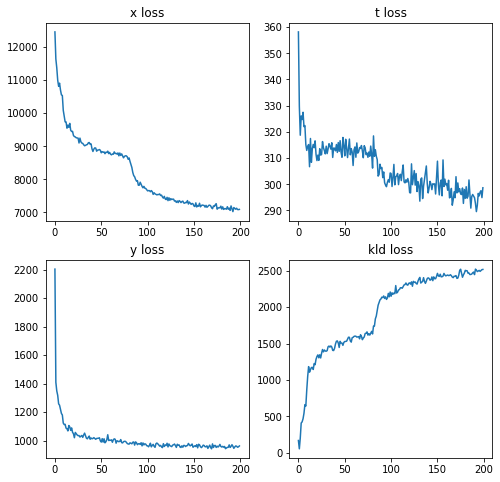

In [10]:
model, losses = train_model(device, plot_curves, print_logs,
              dataloader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=False)

In [141]:
Ey_dot = estimate_model_py_dot(model,n=10000)
print(Ey_dot)
Ey_dot[1] - Ey_dot[0]

[2.40804458 6.28388834]


3.8758437633514404

In [12]:
#True values ~ sort of?
print(ihdp_train['mu1'][:,0].mean())
print(ihdp_train['mu0'][:,0].mean())
print(ihdp_train['mu1'][:,0].mean() - ihdp_train['mu0'][:,0].mean())

6.45146795987858
2.43701736968941
4.0144505901891705


In [178]:
#Estimate based on factual outcomes
sim_run = 0
yfdata = ihdp_train['yf'][:,sim_run]
tdata = ihdp_train['t'][:,sim_run]
print((yfdata*tdata).sum()/(tdata==1).sum())
print((yfdata*(1-tdata)).sum()/(tdata==0).sum())
print((yfdata*tdata).sum()/(tdata==1).sum()-(yfdata*(1-tdata)).sum()/(tdata==0).sum())

6.46072872494169
2.393144606697551
4.06758411824414


In [123]:
ihdp_train['yf'][ihdp_train['t']==1]

array([ 4.77123234,  6.65992586,  3.74822257, ..., 10.41272884,
        9.48914554,  8.75471345])

In [132]:
ITE = np.zeros(ihdp_train['yf'].shape)
ITE = (ihdp_train['yf'] - ihdp_train['ycf'])*ihdp_train['t'] + (ihdp_train['ycf'] - ihdp_train['yf'])*(1-ihdp_train['t'])

In [182]:
ITE[:,0].mean()

4.033316926957236

In [194]:
ihdp_train['t'][:,10].mean()

0.18452380952380953

## Notes
- Doesn't quite get the right result, but close
- What if we use the extra simulation draws to mimic larger data sets to see how the p(y|do(t)) function gets closer to the real thing? <- won't work
- We get a pretty good E[y|do(t)] result with only the factual outcomes...
    - What's the point of ATE errors in previous articles?
        - To measure the overall bias resulted from using the estimator for ITE inference?
        - Should I be doing the ITE inference as well? => not necessarily, if we focus on the population level quantities like in effect restoration papers. Could argue that it's the most plausible usecase for CEVAE and necessary for correct ITE inference
- Why do the mean values of yf vary so much between simulation runs? Were they sampled somehow differently?
    - The data generating process is sampled like in Hill 2011, https://github.com/vdorie/npci/tree/master/examples/ihdp_sim has code that does that
    - I could generate new yf:s (and ycf:s) and get the true ATE:s and true ITE:s directly. Again, why isn't it done like that in the ML papers?
- Do we want sample ATE estimates or population estimates? The natural thing for effect restoration is population level estimates, but as mentioned in the Hill paper, usually that's not done if we assume ignorability, because the sample might not be randomly selected from the population and the population ATE is not that useful anyways.
    - So, for other papers the out-of-sample and within-sample ATE errors can make sense, but not necessarily with CEVAE
    - Especially non-parametric causal inference tends to focus on sample estimates because population estimates are difficult
- What can we even do with this data set if population level quantities are not necessarily not plausible to compute?
    - Would need to do ITE inference after all for sample estimates
    - Maybe could just forget that and assume X are randomly sampled? => get the "true" effect with that assumption

# Kysymyksiä
- Miten näitä "oikeita" datasettejä voi käyttää identifioinnin tutkimiseen?
    - Ajamalla mallin vain kerran täydelle datasetille?
    - Vai voiko jotenkin tehdä esim. (otoskoko, ATE-virhe) -plotin, josta näkisi jonkinlaisen konvergoitumisen?
- Otosestimaatit vai populaatioestimaatit?
    - Otosestimaatteja voi tehdä ITE-estimaateilla
    - Mutta siihen tarvitaan CEVAE:lla oletus, että malli estimoi koko populaation todennäköisyysjakauman
        - Populaatio-ATE siis siinä mielessä oleellisempi kuin otos-ATE

# Train new data generator

In [7]:
from datagenVAE import GenericDataset, train_datagenerator, savemodel, loadmodel, trainZtoTmodel, dataGeneratorVAE, FullyConnected
dataset = GenericDataset(ihdp_x_train[:,:,0])
dataloader = DataLoader(dataset, shuffle=True, batch_size=32)

In [8]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=400
lr_start=0.02
lr_end=0.001
x_dim=ihdp_x_train.shape[1]
z_dim=10
x_mode=[0]*3+[4]+[0]*2+[2]*(x_dim-6)

In [9]:
proxymodel, losses = train_datagenerator(device, plot_curves, print_logs,
              dataloader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30, x_mode=x_mode)

Epoch 0:
Epoch loss: 12430.217590332031
x: 12365.564331054688, kld: 64.65318512916565
Epoch 1:
Epoch loss: 11448.669311523438
x: 11079.958740234375, kld: 368.7106046676636
Epoch 2:
Epoch loss: 11475.939514160156
x: 10905.618072509766, kld: 570.3214282989502
Epoch 3:
Epoch loss: 11257.910827636719
x: 10742.874206542969, kld: 515.0366172790527
Epoch 4:
Epoch loss: 11213.114776611328
x: 10615.28451538086, kld: 597.8302478790283
Epoch 5:


KeyboardInterrupt: 

In [10]:
savemodel(proxymodel, "proxygenerator")

In [9]:
proxymodel = loadmodel(name="proxygenerator", modeltype=dataGeneratorVAE, args=[x_dim, z_dim, device, 3, 30, 3, 30, x_mode])

In [15]:
z_sample, x_sample = proxymodel.sample(10000)

(array([   4.,    4.,   13.,   37.,   58.,  100.,  163.,  229.,  403.,
         514.,  685.,  883.,  958.,  927., 1024.,  890.,  794.,  709.,
         541.,  388.,  248.,  190.,  105.,   58.,   33.,   20.,   11.,
           5.,    2.,    4.]),
 array([-3.4550736 , -3.20931196, -2.96355033, -2.7177887 , -2.47202706,
        -2.22626543, -1.9805038 , -1.73474216, -1.48898053, -1.2432189 ,
        -0.99745727, -0.75169563, -0.505934  , -0.26017237, -0.01441073,
         0.2313509 ,  0.47711253,  0.72287416,  0.9686358 ,  1.21439743,
         1.46015906,  1.7059207 ,  1.95168233,  2.19744396,  2.4432056 ,
         2.68896723,  2.93472886,  3.18049049,  3.42625213,  3.67201376,
         3.91777539]),
 <a list of 30 Patch objects>)

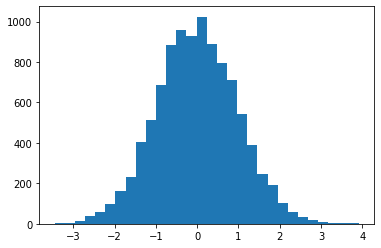

In [16]:
plt.hist(x_sample[:,4], bins=30)

(array([ 1.,  0.,  0.,  1.,  1.,  2.,  0.,  2.,  3.,  1.,  4.,  8.,  6.,
         9., 18., 23., 23., 47., 50., 61., 78., 73., 77., 68., 45., 38.,
        13.,  8.,  6.,  6.]),
 array([-5.13042776, -4.88035896, -4.63029015, -4.38022134, -4.13015253,
        -3.88008372, -3.63001491, -3.3799461 , -3.12987729, -2.87980848,
        -2.62973967, -2.37967086, -2.12960205, -1.87953324, -1.62946443,
        -1.37939562, -1.12932681, -0.879258  , -0.62918919, -0.37912038,
        -0.12905157,  0.12101724,  0.37108604,  0.62115485,  0.87122366,
         1.12129247,  1.37136128,  1.62143009,  1.8714989 ,  2.12156771,
         2.37163652]),
 <a list of 30 Patch objects>)

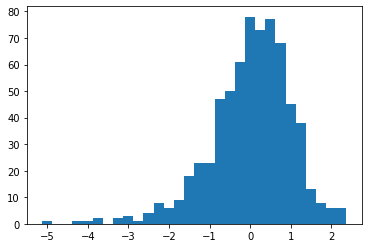

In [18]:
plt.hist(ihdp_x_train[:,4,0],bins=30)

### Next
- Create, train the x -> t model and sample the t:s as well
- Then y according to some decision surface (look at the Hill paper) (should have sampled parameters)
    - Have possibility for continuous z and binary/categorical
- Bundle these up to ease use for training CEVAE
- Then code up some CEVAE stuff like loading saved models, and running the model for different data sets

- Data generating function: Sample proxies, sample t, generate y according to rule
    - Need the VAE and trained z->t model, also y generating parameters
    - Output as a dataframe that works with cevatetools.py CEVAEDataset
- Function that cycles through generated data sets and outputs results like before (can we use the exact same function?)

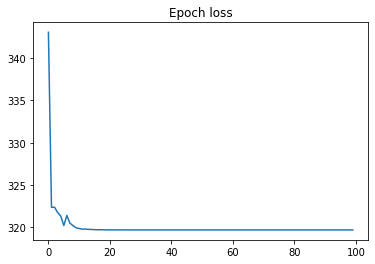

In [237]:
model_zt = trainZtoTmodel(device, ihdp_x_train[:,0,0][:,None], ihdp_train['t'][:,0][:,None], lr_start=0.05, lr_end=0.01, num_epochs=100,layers=3, width=10)

In [266]:
savemodel(model_zt, "ztotgenerator")

In [10]:
model_zt = loadmodel("ztotgenerator", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

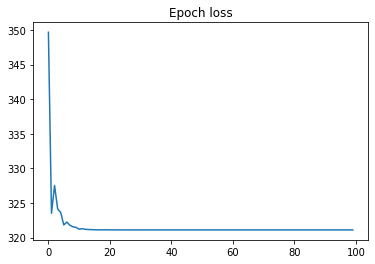

In [20]:
model_zt = trainZtoTmodel(device, ihdp_x_train[:,4,0][:,None], ihdp_train['t'][:,0][:,None], lr_start=0.05, lr_end=0.01, num_epochs=100,layers=3, width=10)

In [22]:
savemodel(model_zt, "ztotgenerator4")

In [11]:
model_zt = loadmodel("ztotgenerator4", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

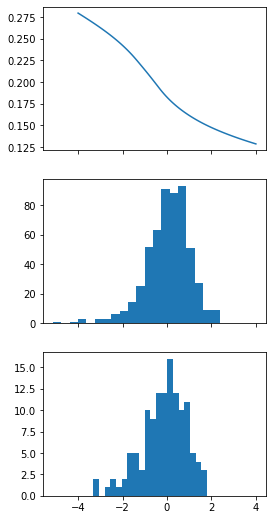

array([[0.15163713, 0.03706784],
       [0.03706784, 1.00651219]])

In [12]:
z = torch.Tensor(np.linspace(-4,4,100)[:,None])
t_pred = model_zt(z)
fig, ax = plt.subplots(3,1,figsize=(4,9), sharex=True)
ax[0].plot(z.detach(), torch.sigmoid(t_pred).detach())
ax[1].hist(ihdp_x_train[:,4,0][ihdp_train['t'][:,0]==0], bins=20)
ax[2].hist(ihdp_x_train[:,4,0][ihdp_train['t'][:,0]==1], bins=20)
plt.show()
np.cov(ihdp_train['t'][:,0], ihdp_x_train[:,0,0])

# Try out CEVAE on the latent IHDP dataset, continuous true z

In [ ]:
from datagenVAE import generatedata

## Screen out good variable as z

R squared:  0.7194292984526307
Some predictions:
[ 0.08075207 -1.48529303 -0.81958879 -0.03005426 -0.32010524  0.29347359
  0.7129205   1.03090737 -0.47593015  0.40126758]
True values:
[ 0.16802979 -2.3905694  -1.0795941   0.35727215 -0.07809806  0.64490026
  0.5110993   0.57308775 -1.1950824   0.50790465]


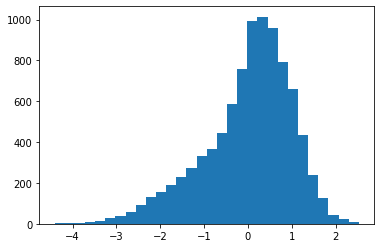

In [110]:
# Investigate how well can we predict the 4th x from the others (how much information shared)
from sklearn.ensemble import RandomForestRegressor
var_num = 1
df_screen = generatedata(10000, proxymodel, model_zt, 1, var_num)
cols = df_screen.columns.str.startswith("x")
data_x = df_screen.iloc[:,cols].to_numpy()
train_predictors = data_x[:-1000]
test_predictors = data_x[-1000:]
train_predicted = df_screen['z'].iloc[:-1000].to_numpy()#data[:-1000,var_num]
test_predicted = df_screen['z'].iloc[-1000:].to_numpy()
rf = RandomForestRegressor().fit(train_predictors, train_predicted)
print("R squared: ", rf.score(test_predictors,test_predicted))
print("Some predictions:")
print(rf.predict(test_predictors[:10,:]))
print("True values:")
print(test_predicted[:10])
plt.hist(train_predicted, bins=30)
plt.show()

## Figure out the rejection sampling

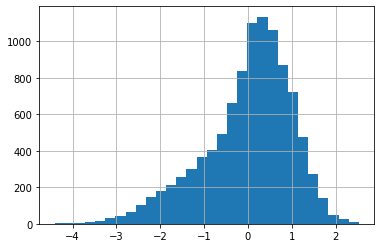

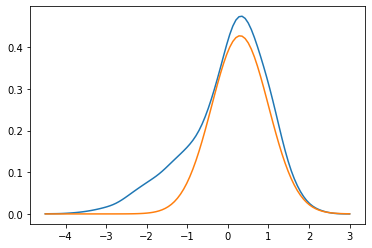

In [111]:
df_screen['z'].hist(bins=30)
from sklearn.neighbors import KernelDensity
kd = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(df_screen['z'][:,None])
z_range = np.linspace(-4.5,3,100)[:,None]
density = np.exp(kd.score_samples(z_range))
plt.figure()
plt.plot(z_range,density)
from scipy.stats import norm
plt.plot(z_range,norm(loc=0.3,scale=0.7).pdf(z_range)*0.75)

In [60]:
density_estimate_fun = lambda z: np.exp(kd.score_samples(z)).squeeze()
sample_fun = lambda z: norm(loc=0.3,scale=0.7).pdf(z)*0.75

## Train model

In [71]:
device='cpu'
plot_curves=False
print_logs=True
num_epochs=100
lr_start=0.03
lr_end=0.001
z_dim=10
zvar_index = 1
num_samples = 13000
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
ATE = 1
df = generatedata(num_samples, proxymodel, model_zt, ATE, zvar_index)
df_r = rejection_sample(df, density_estimate_fun, sample_fun)
dataset = CEVAEDataset(df_r)
train_loader = DataLoader(dataset, shuffle=True, batch_size = 200)

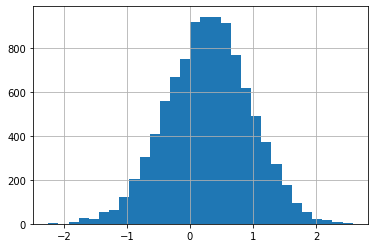

In [113]:
df_r['z'].hist(bins=30)

Epoch 0:
Epoch loss: 174088.91760253906
x: 151465.39143371582, t: 4717.683430671692, y: 15954.43938446045, kld: 1951.4036960601807
Epoch 1:
Epoch loss: 168557.38037109375
x: 143632.22743225098, t: 4614.471927165985, y: 15118.377592086792, kld: 5192.303596496582
Epoch 2:
Epoch loss: 167610.8865966797
x: 141644.8828277588, t: 4614.162278175354, y: 15026.356632232666, kld: 6325.4847021102905
Epoch 3:
Epoch loss: 166983.92584228516
x: 140587.35275268555, t: 4598.352837562561, y: 14996.797853469849, kld: 6801.4215087890625
Epoch 4:
Epoch loss: 167075.80087280273
x: 140338.41720581055, t: 4601.029965400696, y: 14885.658042907715, kld: 7250.695956230164
Epoch 5:
Epoch loss: 166867.97909545898
x: 140202.40927124023, t: 4600.879607200623, y: 14900.710163116455, kld: 7163.9796352386475
Epoch 6:
Epoch loss: 166849.8653869629
x: 139819.08502197266, t: 4604.401014328003, y: 14971.065406799316, kld: 7455.313589096069
Epoch 7:
Epoch loss: 166277.50900268555
x: 139097.29164123535, t: 4599.951471328735

Epoch loss: 155901.18133544922
x: 114036.99513244629, t: 4576.871804237366, y: 14727.17491722107, kld: 22560.139587402344
Epoch 64:
Epoch loss: 155901.82385253906
x: 113987.85874938965, t: 4574.454159259796, y: 14780.506860733032, kld: 22559.003288269043
Epoch 65:
Epoch loss: 155794.73791503906
x: 113946.4875793457, t: 4575.606385231018, y: 14757.98225402832, kld: 22514.661586761475
Epoch 66:
Epoch loss: 155971.7407836914
x: 113927.31085205078, t: 4573.857821464539, y: 14749.523826599121, kld: 22721.048557281494
Epoch 67:
Epoch loss: 155881.50456237793
x: 113939.88662719727, t: 4573.227741718292, y: 14769.070430755615, kld: 22599.320178985596
Epoch 68:
Epoch loss: 155926.01237487793
x: 113796.2756652832, t: 4574.01113986969, y: 14751.02714920044, kld: 22804.69887161255
Epoch 69:
Epoch loss: 155799.94453430176
x: 113710.85939025879, t: 4574.167592048645, y: 14736.447374343872, kld: 22778.470344543457
Epoch 70:
Epoch loss: 155796.47903442383
x: 113686.78703308105, t: 4576.256383895874, y

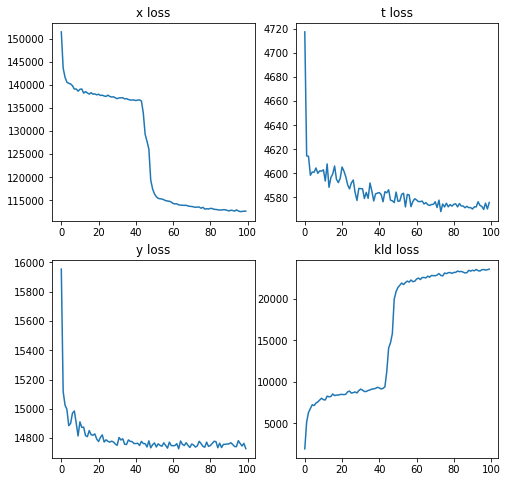

In [72]:
from cevaetools import train_model
model, losses = train_model(device, plot_curves, print_logs,
              train_loader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=3, p_y_zt_nn_width=30, 
              p_t_z_nn_layers=3, p_t_z_nn_width=30,
              p_x_z_nn_layers=3, p_x_z_nn_width=30,
              q_z_nn_layers=3, q_z_nn_width=30,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=True)

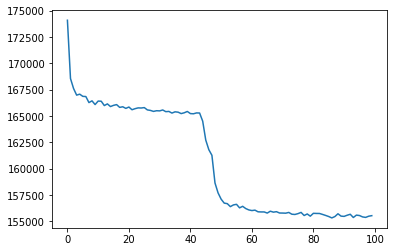

In [73]:
plt.plot(losses['total'])

In [90]:
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression().fit(df_r['z'][df_r['t']==1].to_numpy()[:,None],df_r['y'][df_r['t']==1].to_numpy()[:,None])
lr0 = LinearRegression().fit(df_r['z'][df_r['t']==0].to_numpy()[:,None],df_r['y'][df_r['t']==0].to_numpy()[:,None])
print(lr1.predict(df_r['z'][:,None]).mean())
print(lr0.predict(df_r['z'][:,None]).mean())

1.2771595
0.29146218


In [88]:
estimate_model_py_dot(model)

array([0.30506337, 1.27292383])

In [114]:
from sklearn.ensemble import RandomForestRegressor
cols = df_r.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df_r.iloc[:,cols].loc[df_r.t==1], df_r["y"][df_r.t==1])
rf0 = RandomForestRegressor().fit(df_r.iloc[:,cols].loc[df_r.t==0], df_r["y"][df_r.t==0])
print(rf1.predict(df_r.iloc[:,cols]).mean())
print(rf0.predict(df_r.iloc[:,cols]).mean())

1.2492027495680393
0.2962871027967168


In [379]:
print(df["y"][df.t==1].mean())
print(df["z"].mean()+ATE)
print(df["y"][df.t==0].mean())
print(df["z"].mean())

0.8886077
1.0168584659695625
0.060804058
0.016858466


In [50]:
len(df['z'])

include = (norm(loc=0.3,scale=0.7).pdf(df['z'])*0.75 / np.exp(kd.score_samples(df['z'][:,None])).squeeze()) > np.random.random(len(df['z']))

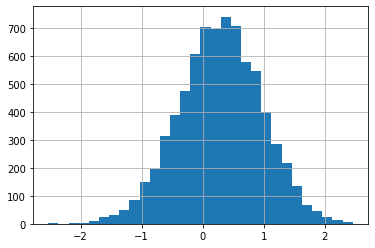

In [53]:
df['z'][include].hist(bins=30)

In [55]:
len(df['z'][include])

7507

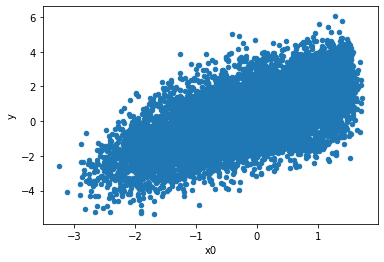

In [224]:
df.plot.scatter('x0','y')

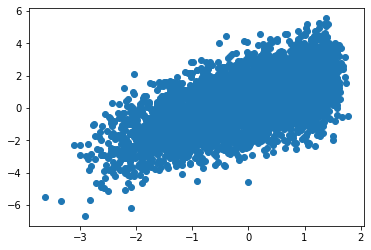

In [225]:
zs, xs, ts, ys = model.sample(5000)
plt.scatter(xs[:,0],ys)

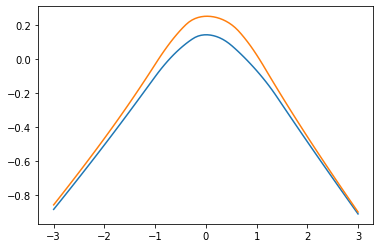

In [336]:
zrange = torch.Tensor(np.linspace(-3,3,100))[:,None]
ydot1 = model.decoder.y_nn(torch.cat([zrange, torch.ones(100,1)],1))[:,0]
ydot0 = model.decoder.y_nn(torch.cat([zrange, torch.zeros(100,1)],1))[:,0]
plt.plot(zrange.detach(), ydot1.detach())
plt.plot(zrange.detach(), ydot0.detach())

(array([   3.,    5.,    8.,   11.,   31.,   42.,   73.,  106.,  149.,
         154.,  205.,  240.,  264.,  320.,  333.,  405.,  564.,  706.,
         847., 1002., 1068., 1008.,  866.,  676.,  409.,  266.,  147.,
          58.,   23.,   11.]),
 array([-4.1352444 , -3.915488  , -3.6957319 , -3.4759755 , -3.2562191 ,
        -3.036463  , -2.8167067 , -2.5969505 , -2.3771942 , -2.1574378 ,
        -1.9376816 , -1.7179253 , -1.4981691 , -1.2784128 , -1.0586565 ,
        -0.8389002 , -0.6191439 , -0.39938766, -0.17963138,  0.0401249 ,
         0.25988117,  0.47963744,  0.69939375,  0.91915   ,  1.1389062 ,
         1.3586626 ,  1.5784189 ,  1.7981751 ,  2.0179315 ,  2.2376876 ,
         2.457444  ], dtype=float32),
 <a list of 30 Patch objects>)

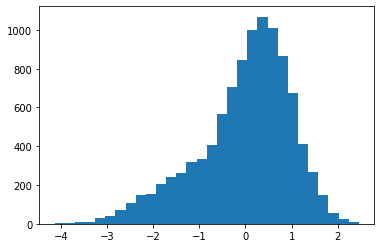

In [199]:
plt.hist(data[:,1],bins=30)

# Try out CEVAE on the latent IHDP dataset, binary true z

In [25]:
#Check out which x has a high correlation with t
np.cov(ihdp_train['x'][:,5,0], ihdp_train['t'][:,0])

array([[1.01561014, 0.04188027],
       [0.04188027, 0.15163713]])

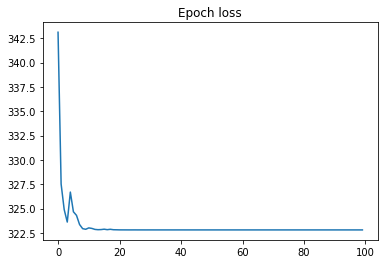

In [72]:
model_zt = trainZtoTmodel(device, ihdp_x_train[:,6,0][:,None], ihdp_train['t'][:,0][:,None], lr_start=0.05, lr_end=0.01, num_epochs=100,layers=3, width=10)

In [74]:
savemodel(model_zt, "ztotgenerator6")

In [75]:
model_zt = loadmodel("ztotgenerator6", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

In [76]:
model_zt = lambda z: 2*z-0.5

In [84]:
from datagenVAE import generatedata
device='cpu'
plot_curves=False
print_logs=True
num_epochs=300
lr_start=0.0001
lr_end=0.00001
z_dim=1
zvar_index = 6
num_samples = 5000
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
df = generatedata(num_samples, proxymodel, model_zt, 0.1, zvar_index)
dataset = CEVAEDataset(df)
train_loader = DataLoader(dataset, shuffle=True, batch_size = 200)

Epoch 0:
Epoch loss: 130801.39013671875
x: 118614.43212890625, t: 3810.7147064208984, y: 8322.457092285156, kld: 53.7868754863739
Epoch 1:
Epoch loss: 130440.67919921875
x: 118282.31640625, t: 3794.9776306152344, y: 8285.054962158203, kld: 78.33161497116089
Epoch 2:
Epoch loss: 130096.0380859375
x: 117958.67822265625, t: 3779.7789459228516, y: 8250.246063232422, kld: 107.33506035804749
Epoch 3:
Epoch loss: 129767.75927734375
x: 117644.51123046875, t: 3765.313735961914, y: 8218.195220947266, kld: 139.73923540115356
Epoch 4:
Epoch loss: 129454.00537109375
x: 117339.65576171875, t: 3751.539520263672, y: 8187.721984863281, kld: 175.09009265899658
Epoch 5:
Epoch loss: 129155.31640625
x: 117044.4892578125, t: 3738.143844604492, y: 8158.919982910156, kld: 213.7635679244995
Epoch 6:
Epoch loss: 128870.587890625
x: 116759.41796875, t: 3725.5445556640625, y: 8131.867584228516, kld: 253.7604627609253
Epoch 7:
Epoch loss: 128597.34423828125
x: 116483.9228515625, t: 3713.109634399414, y: 8105.69256

Epoch loss: 120684.17919921875
x: 108848.7197265625, t: 3405.0150451660156, y: 7612.676696777344, kld: 817.7637577056885
Epoch 65:
Epoch loss: 120594.93994140625
x: 108759.90771484375, t: 3403.2238159179688, y: 7611.298156738281, kld: 820.5098056793213
Epoch 66:
Epoch loss: 120506.49658203125
x: 108671.55615234375, t: 3401.515853881836, y: 7610.0728759765625, kld: 823.3517646789551
Epoch 67:
Epoch loss: 120419.05908203125
x: 108583.6376953125, t: 3399.8197021484375, y: 7608.885009765625, kld: 826.7154006958008
Epoch 68:
Epoch loss: 120332.59423828125
x: 108497.3466796875, t: 3398.2547454833984, y: 7607.714050292969, kld: 829.2794036865234
Epoch 69:
Epoch loss: 120247.04736328125
x: 108411.3818359375, t: 3396.6991119384766, y: 7606.656646728516, kld: 832.3079109191895
Epoch 70:
Epoch loss: 120162.28662109375
x: 108325.7431640625, t: 3395.2129516601562, y: 7605.582183837891, kld: 835.7481441497803
Epoch 71:
Epoch loss: 120078.57958984375
x: 108241.7314453125, t: 3393.7903747558594, y: 76

Epoch loss: 116426.82275390625
x: 104491.3212890625, t: 3360.8004150390625, y: 7586.572784423828, kld: 988.1276435852051
Epoch 129:
Epoch loss: 116378.1630859375
x: 104440.8232421875, t: 3360.6475677490234, y: 7586.56689453125, kld: 990.1285095214844
Epoch 130:
Epoch loss: 116330.07421875
x: 104391.1435546875, t: 3360.5213928222656, y: 7586.575866699219, kld: 991.8344535827637
Epoch 131:
Epoch loss: 116282.373046875
x: 104342.45947265625, t: 3360.3797454833984, y: 7586.406188964844, kld: 993.1280517578125
Epoch 132:
Epoch loss: 116234.93896484375
x: 104293.52880859375, t: 3360.249725341797, y: 7586.393737792969, kld: 994.764575958252
Epoch 133:
Epoch loss: 116188.13818359375
x: 104245.20849609375, t: 3360.126235961914, y: 7586.353912353516, kld: 996.4494323730469
Epoch 134:
Epoch loss: 116141.6171875
x: 104197.2822265625, t: 3360.0303649902344, y: 7586.314849853516, kld: 997.9879570007324
Epoch 135:
Epoch loss: 116095.4873046875
x: 104149.57275390625, t: 3359.894989013672, y: 7586.3299

Epoch loss: 114052.5341796875
x: 102054.63623046875, t: 3357.5161895751953, y: 7585.698516845703, kld: 1054.6850624084473
Epoch 192:
Epoch loss: 114024.21142578125
x: 102025.72119140625, t: 3357.513137817383, y: 7585.734100341797, kld: 1055.2437210083008
Epoch 193:
Epoch loss: 113995.9443359375
x: 101996.978515625, t: 3357.4991912841797, y: 7585.744445800781, kld: 1055.720287322998
Epoch 194:
Epoch loss: 113968.04638671875
x: 101968.271484375, t: 3357.4893493652344, y: 7585.727325439453, kld: 1056.5576362609863
Epoch 195:
Epoch loss: 113940.23974609375
x: 101939.82373046875, t: 3357.474624633789, y: 7585.716735839844, kld: 1057.223129272461
Epoch 196:
Epoch loss: 113912.78759765625
x: 101911.99462890625, t: 3357.461959838867, y: 7585.690277099609, kld: 1057.6418571472168
Epoch 197:
Epoch loss: 113885.4970703125
x: 101883.935546875, t: 3357.4554595947266, y: 7585.714752197266, kld: 1058.3911247253418
Epoch 198:
Epoch loss: 113858.52099609375
x: 101856.31713867188, t: 3357.4458923339844,

Epoch loss: 112666.41650390625
x: 100638.49560546875, t: 3357.188751220703, y: 7585.902740478516, kld: 1084.828182220459
Epoch 254:
Epoch loss: 112649.24072265625
x: 100620.87426757812, t: 3357.186477661133, y: 7585.892883300781, kld: 1085.2874946594238
Epoch 255:
Epoch loss: 112632.2548828125
x: 100603.60913085938, t: 3357.181137084961, y: 7585.895721435547, kld: 1085.5664329528809
Epoch 256:
Epoch loss: 112615.3955078125
x: 100586.474609375, t: 3357.1757049560547, y: 7585.880615234375, kld: 1085.8654174804688
Epoch 257:
Epoch loss: 112598.693359375
x: 100569.35009765625, t: 3357.1715393066406, y: 7585.9129638671875, kld: 1086.2605361938477
Epoch 258:
Epoch loss: 112582.10546875
x: 100552.53564453125, t: 3357.174819946289, y: 7585.898651123047, kld: 1086.4960670471191
Epoch 259:
Epoch loss: 112565.66162109375
x: 100535.56469726562, t: 3357.175064086914, y: 7585.906890869141, kld: 1087.014419555664
Epoch 260:
Epoch loss: 112549.33740234375
x: 100518.92553710938, t: 3357.1751861572266, 

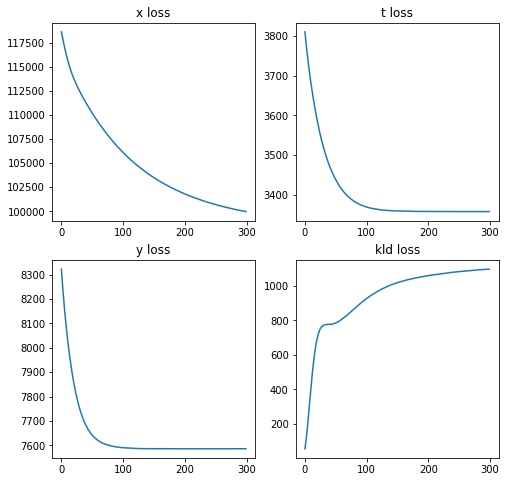

In [85]:
model, losses = train_model(device, plot_curves, print_logs,
              train_loader, num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers=1, p_y_zt_nn_width=10, 
              p_t_z_nn_layers=1, p_t_z_nn_width=10,
              p_x_z_nn_layers=0, p_x_z_nn_width=40,
              q_z_nn_layers=1, q_z_nn_width=40,
              t_mode=2, y_mode=0, x_mode=x_mode, ty_separate_enc=False, z_mode=2)

In [86]:
estimate_model_py_dot(model)

array([0.23483491, 0.77389669])

In [89]:
_, zx = proxymodel.sample(num_samples)
np.mean(zx[:,6])
#zvar_index

0.5024

In [90]:
ihdp_x_train[:,6].mean()

0.5141145833333334

In [87]:
prior

tensor([[0.6135],
        [0.3865]])

In [93]:
prior = torch.Tensor([[torch.sigmoid(model.pz_logit)],[1-torch.sigmoid(model.pz_logit)]])
z = torch.Tensor([[0],[1],[0],[1]])
t = torch.Tensor([[0],[0],[1],[1]])
_,_,_,_,y_pred,y_std = model.decoder(z,t)
y_pred

tensor([[0.1960],
        [0.2819],
        [0.7489],
        [0.8042]], grad_fn=<SliceBackward>)

In [158]:
from sklearn.ensemble import RandomForestRegressor
cols = df.columns.str.startswith("x")
rf1 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==1], df["y"][df.t==1])
rf0 = RandomForestRegressor().fit(df.iloc[:,cols].loc[df.t==0], df["y"][df.t==0])
print(rf1.predict(df.iloc[:,cols]).mean())
print(rf0.predict(df.iloc[:,cols]).mean())

0.22608747949188068
-0.03674812453491772


## TODO next:
- Run for different data sizes and see convergence
    - Also for different y|z,t functions, need to include that in the analysis somehow
        - Maybe just run the convergence check multiple times for a few y|z,t? No need fo new code
        - The other papers do 1000 different functions, maybe would be too difficult
        - On the other hand, for 1D z it doesn't make as much sense to try different functions
            - Really, the distribution of x and t is more meaningful than y|z,t here
- Try out also the binary CEVAE (but need to code that or maybe modify the pre-existing thing)
    - Maybe better to code so we can use the same CEVAE code later on too

# Latent IHDP dataset, continuous z, convergence

In [165]:
model_zt = loadmodel("ztotgenerator", modeltype=FullyConnected, args=[[1]+[10]*3+[1]])

In [185]:
datasize = [500,1000,2000,3000,4000,5000]
param_times = 10
folder = "latentIHDP_z0_datasize"
name = "latentIHDPz0"
BATCH_SIZE = 200
generate_data = generatedata
zvar_index = 0
dataparameters = [proxymodel, model_zt, 0.1, zvar_index]
track_function = estimate_model_py_dot
true_value = [0, 0.1]
device = "cpu"
num_epochs = 100
lr_start=0.05
lr_end=0.002
z_dim=20
x_mode=np.delete(np.array([0]*3+[4]+[0]*2+[2]*(ihdp_x_train.shape[1]-6)),zvar_index)
x_dim = len(x_mode)
p_y_zt_nn_layers=3
p_y_zt_nn_width=30 
p_t_z_nn_layers=3
p_t_z_nn_width=30
p_x_z_nn_layers=3
p_x_z_nn_width=30
q_z_nn_layers=3
q_z_nn_width=30
ty_separate_enc=False
t_mode = 2
y_mode = 0
train_arguments = [num_epochs, lr_start, lr_end, x_dim, z_dim,
              p_y_zt_nn_layers, p_y_zt_nn_width, 
              p_t_z_nn_layers, p_t_z_nn_width,
              p_x_z_nn_layers, p_x_z_nn_width,
              q_z_nn_layers, q_z_nn_width,
              t_mode, y_mode, x_mode, ty_separate_enc]
labels = datasize

Creation of the directory data/latentIHDP_z0_datasize/ failed. Trying to empty the same folder.
Training data size 500, run 1


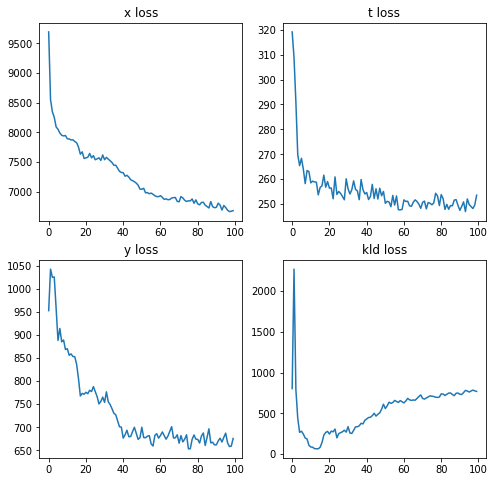

Estimated causal effect: [-0.10256157  0.16576228] true value: [0, 0.1]
Training data size 500, run 2


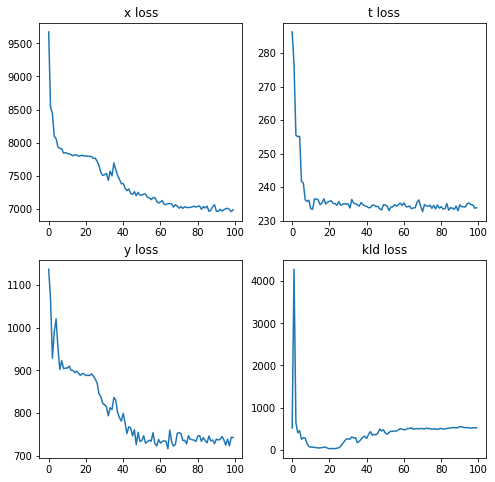

Estimated causal effect: [-0.14552182  0.12725268] true value: [0, 0.1]
Training data size 500, run 3


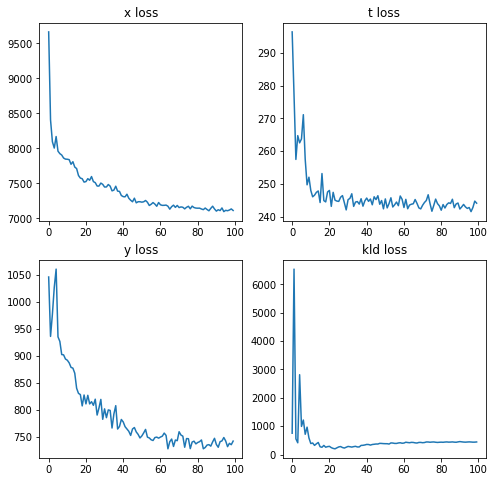

Estimated causal effect: [-0.02817346  0.1938539 ] true value: [0, 0.1]
Training data size 500, run 4


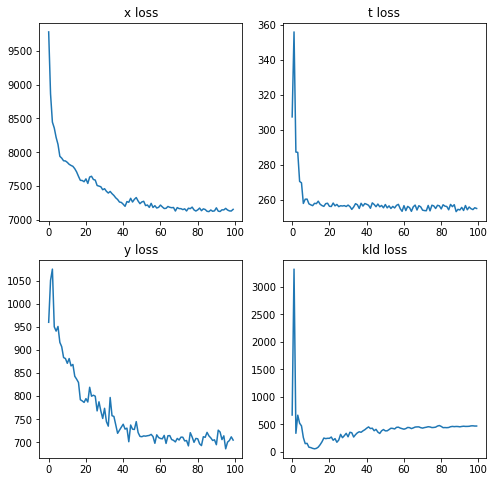

Estimated causal effect: [-0.08675653  0.20351622] true value: [0, 0.1]
Training data size 500, run 5


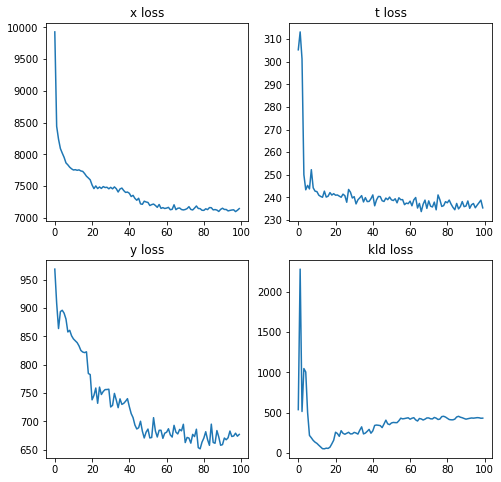

Estimated causal effect: [-0.05466696  0.3931345 ] true value: [0, 0.1]
Training data size 500, run 6


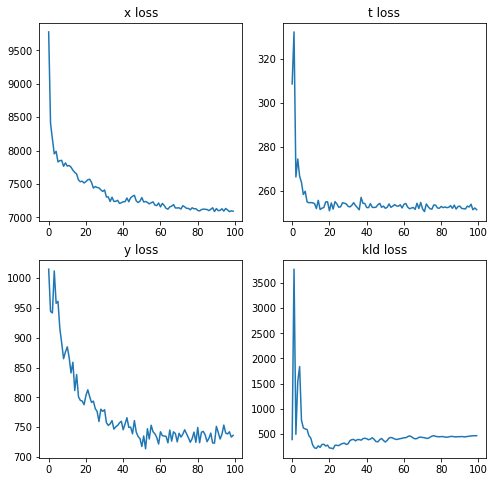

Estimated causal effect: [0.00229067 0.24857645] true value: [0, 0.1]
Training data size 500, run 7


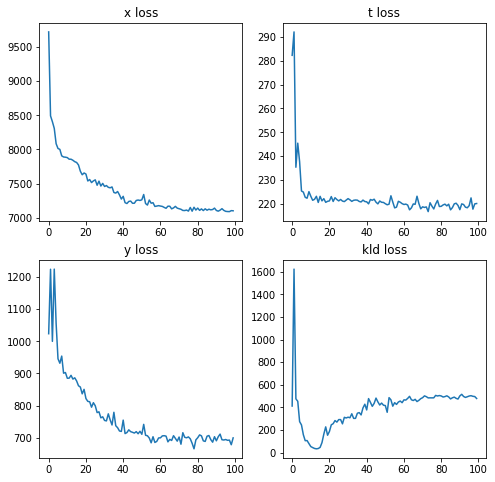

Estimated causal effect: [0.01257226 0.09655951] true value: [0, 0.1]
Training data size 500, run 8


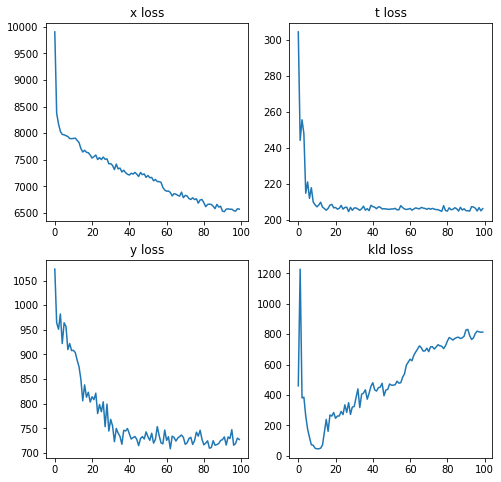

Estimated causal effect: [-0.10137767  0.30742657] true value: [0, 0.1]
Training data size 500, run 9


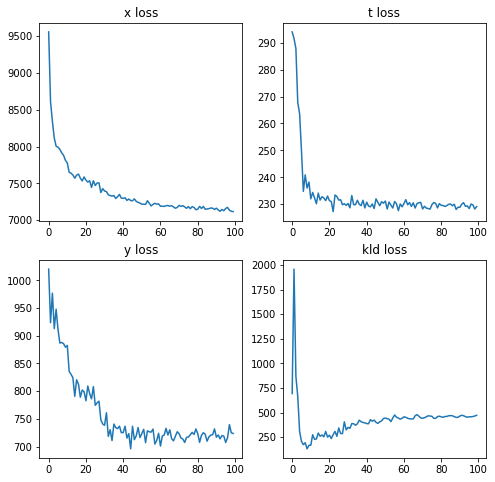

Estimated causal effect: [-0.06718168  0.04435952] true value: [0, 0.1]
Training data size 500, run 10


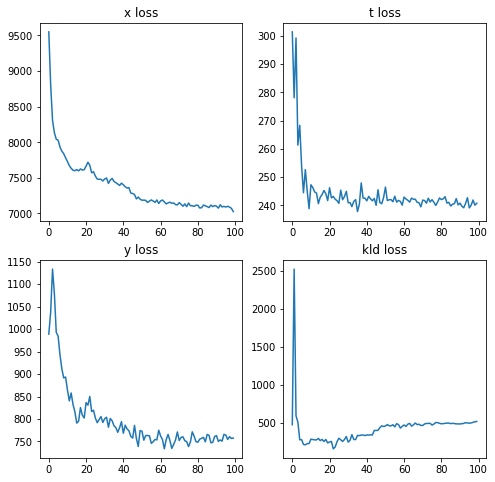

Estimated causal effect: [-0.03439452  0.18986765] true value: [0, 0.1]
Training data size 1000, run 1


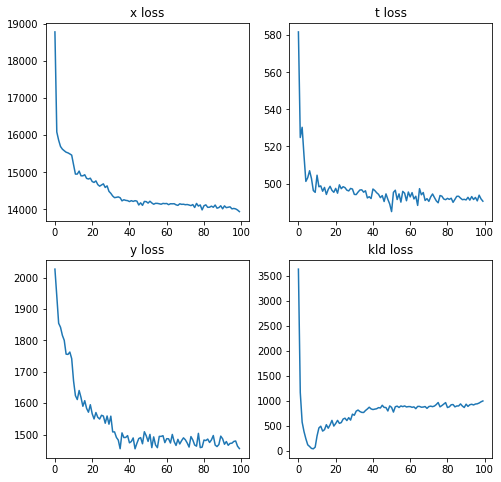

Estimated causal effect: [-0.00347599  0.12499998] true value: [0, 0.1]
Training data size 1000, run 2


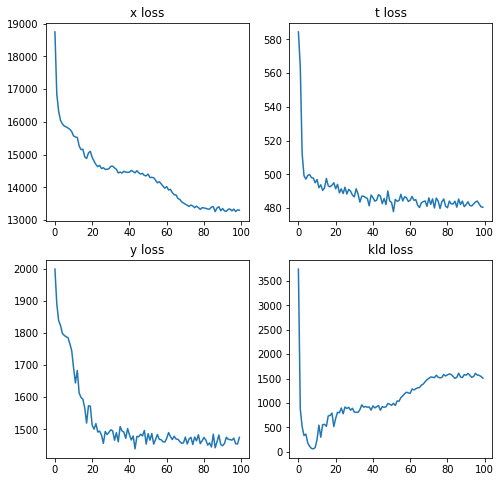

Estimated causal effect: [0.0759872  0.18404454] true value: [0, 0.1]
Training data size 1000, run 3


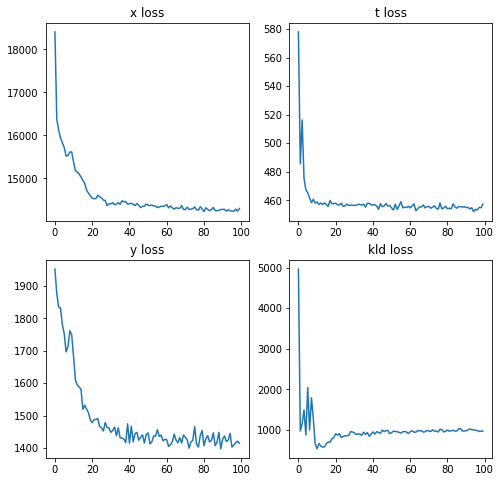

Estimated causal effect: [0.00933333 0.01035243] true value: [0, 0.1]
Training data size 1000, run 4


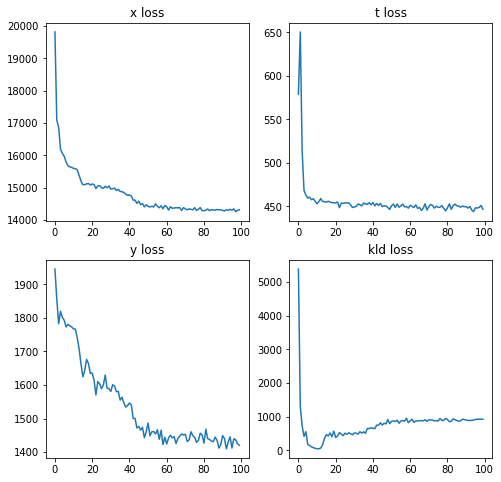

Estimated causal effect: [0.04994817 0.29150817] true value: [0, 0.1]
Training data size 1000, run 5


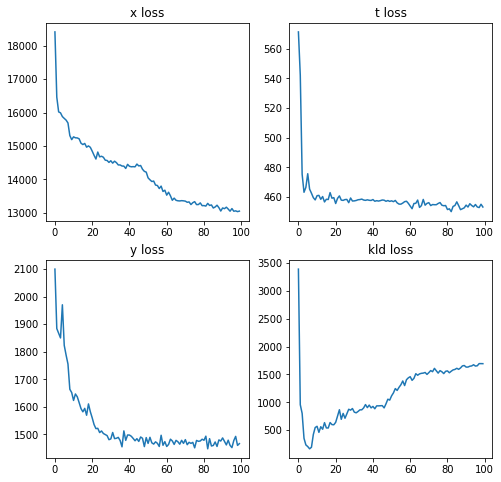

Estimated causal effect: [-0.05260824  0.19295838] true value: [0, 0.1]
Training data size 1000, run 6


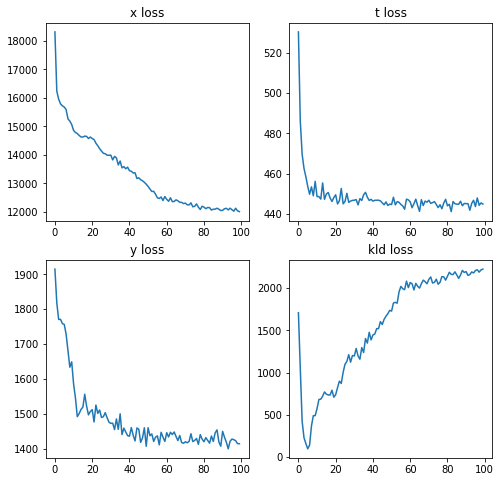

Estimated causal effect: [0.00612611 0.06956139] true value: [0, 0.1]
Training data size 1000, run 7


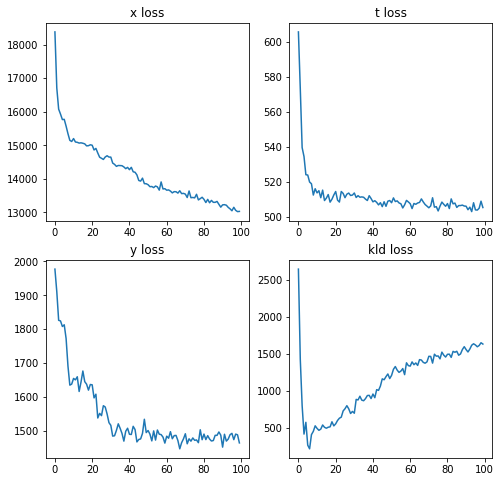

Estimated causal effect: [-0.05291307  0.1274725 ] true value: [0, 0.1]
Training data size 1000, run 8


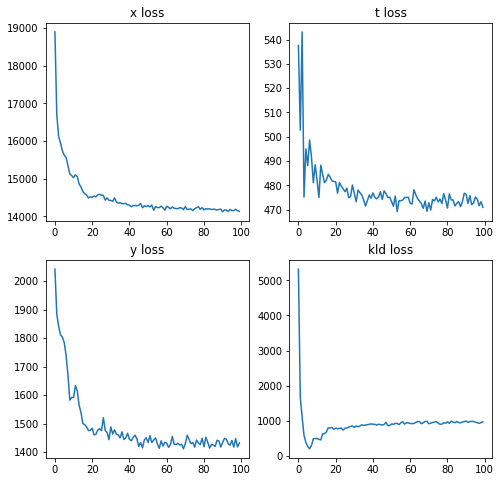

Estimated causal effect: [-0.02963546  0.21506226] true value: [0, 0.1]
Training data size 1000, run 9


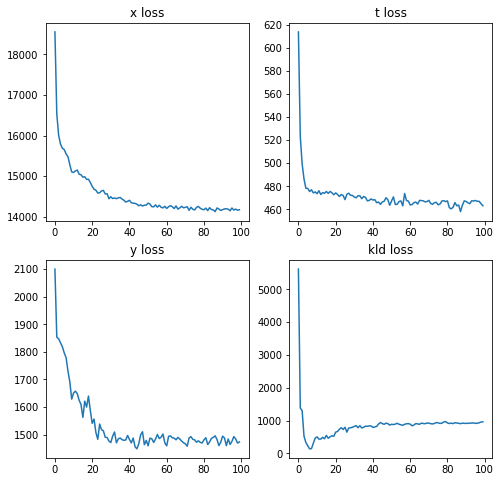

Estimated causal effect: [0.02934918 0.10333828] true value: [0, 0.1]
Training data size 1000, run 10


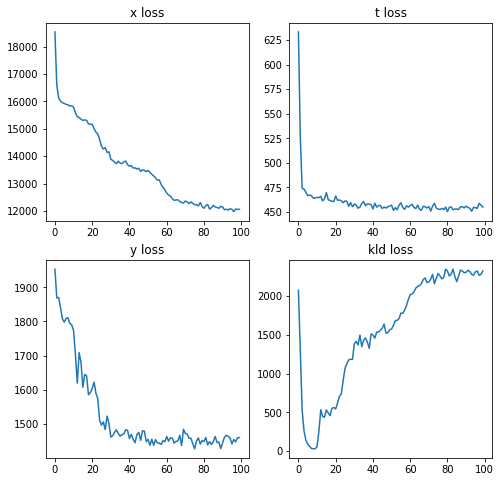

Estimated causal effect: [-0.00078422  0.19612516] true value: [0, 0.1]
Training data size 2000, run 1


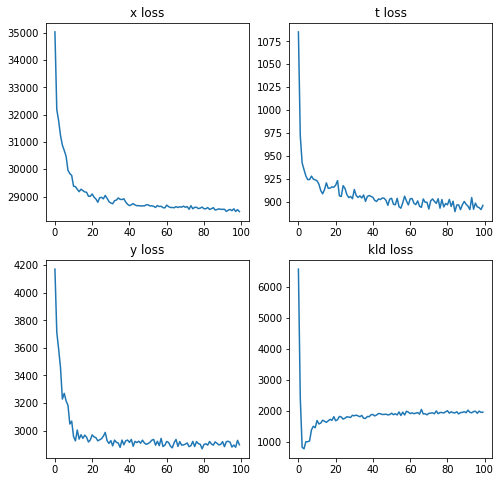

Estimated causal effect: [-0.00219131  0.02883096] true value: [0, 0.1]
Training data size 2000, run 2


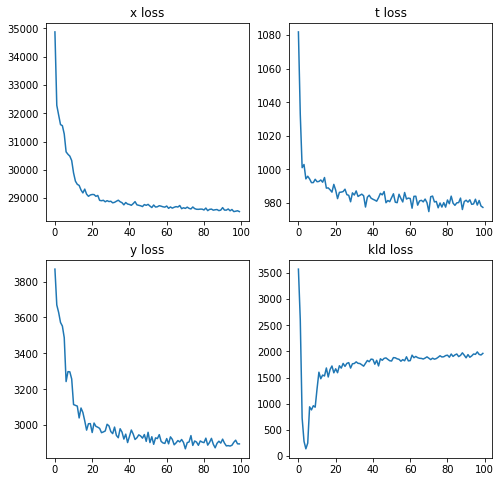

Estimated causal effect: [0.03820901 0.14666435] true value: [0, 0.1]
Training data size 2000, run 3


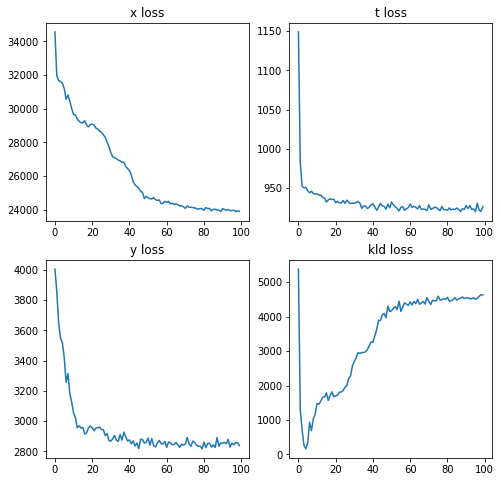

Estimated causal effect: [-0.01439916  0.15095536] true value: [0, 0.1]
Training data size 2000, run 4


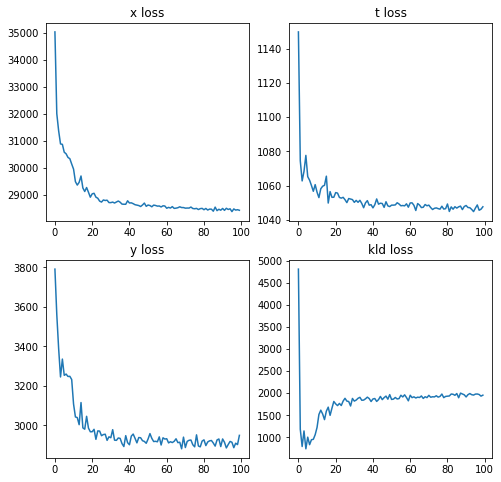

Estimated causal effect: [0.00373714 0.14249723] true value: [0, 0.1]
Training data size 2000, run 5


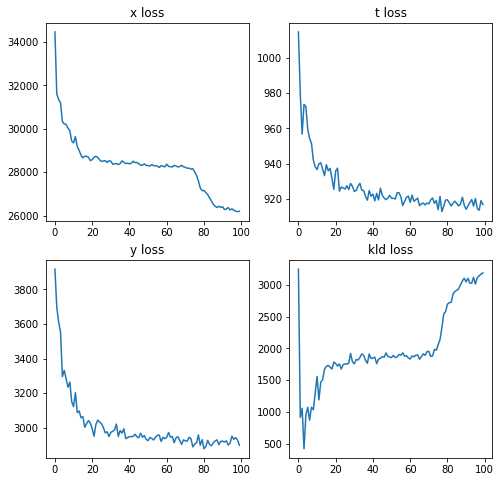

Estimated causal effect: [0.02261829 0.16348237] true value: [0, 0.1]
Training data size 2000, run 6


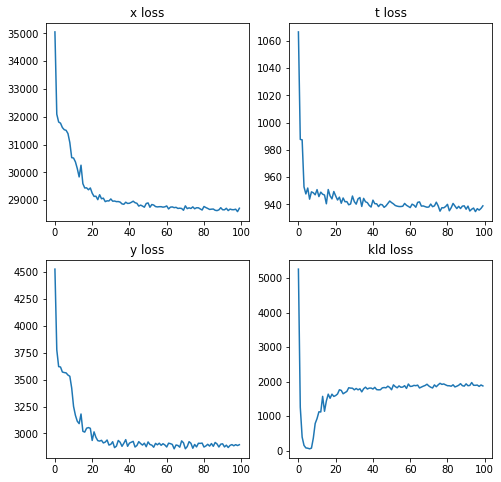

Estimated causal effect: [-0.02775648  0.0151566 ] true value: [0, 0.1]
Training data size 2000, run 7


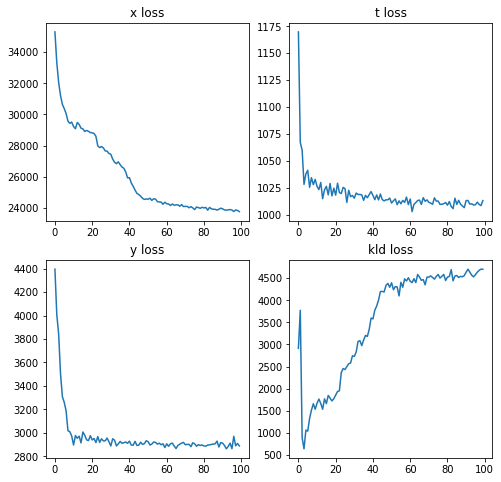

Estimated causal effect: [0.02318204 0.16125198] true value: [0, 0.1]
Training data size 2000, run 8


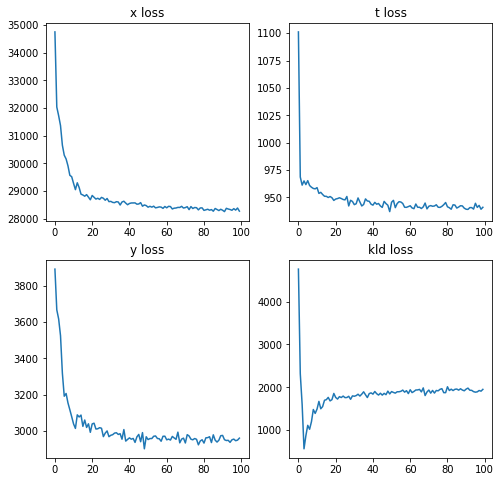

Estimated causal effect: [-0.02009566  0.0188302 ] true value: [0, 0.1]
Training data size 2000, run 9


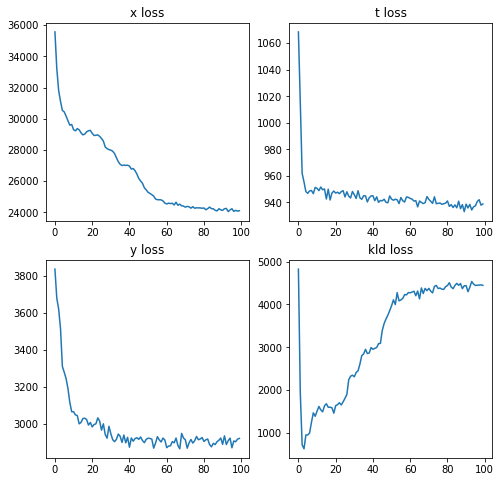

Estimated causal effect: [-0.01589504  0.1905141 ] true value: [0, 0.1]
Training data size 2000, run 10


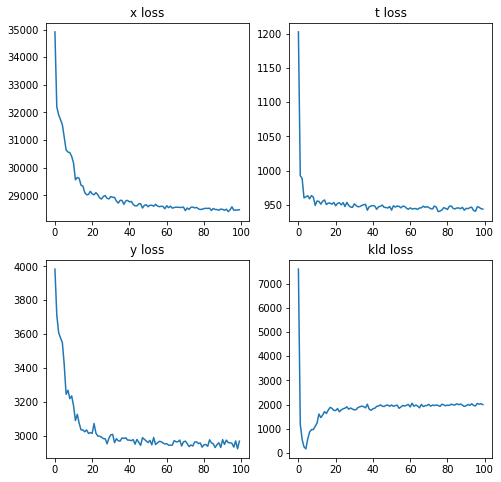

Estimated causal effect: [-0.06613117  0.11739285] true value: [0, 0.1]
Training data size 3000, run 1


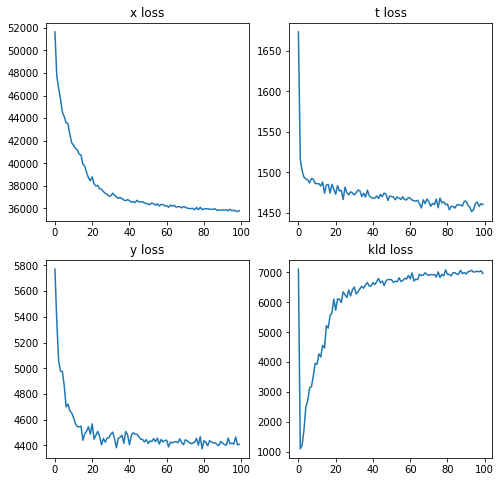

Estimated causal effect: [-0.00831618  0.06841194] true value: [0, 0.1]
Training data size 3000, run 2


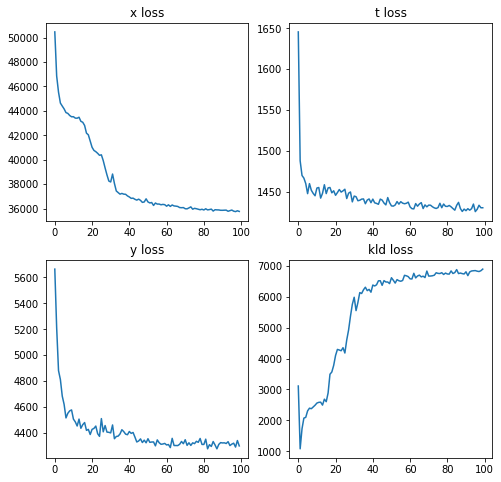

Estimated causal effect: [0.01661814 0.08343745] true value: [0, 0.1]
Training data size 3000, run 3


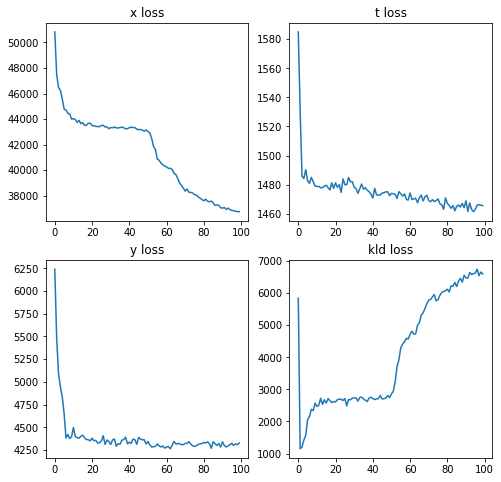

Estimated causal effect: [0.0051796  0.07902696] true value: [0, 0.1]
Training data size 3000, run 4


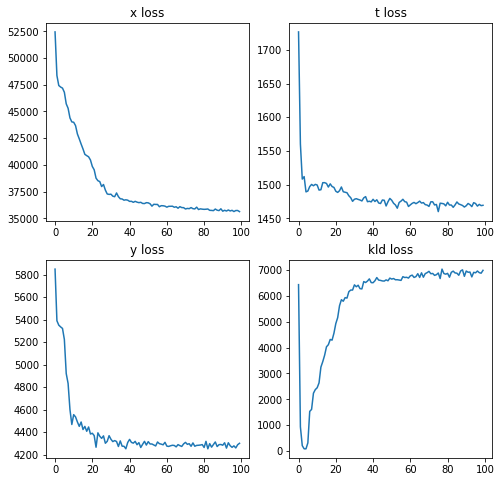

Estimated causal effect: [-0.02582694  0.0138726 ] true value: [0, 0.1]
Training data size 3000, run 5


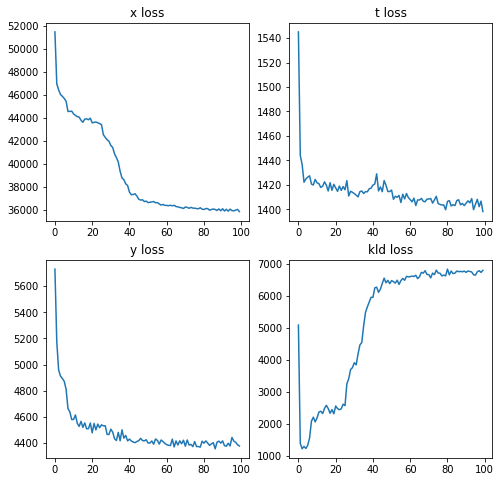

Estimated causal effect: [-0.0103972   0.10876123] true value: [0, 0.1]
Training data size 3000, run 6


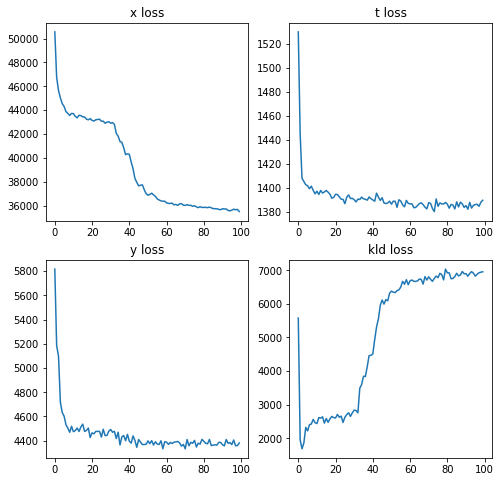

Estimated causal effect: [-0.02790071  0.14831783] true value: [0, 0.1]
Training data size 3000, run 7


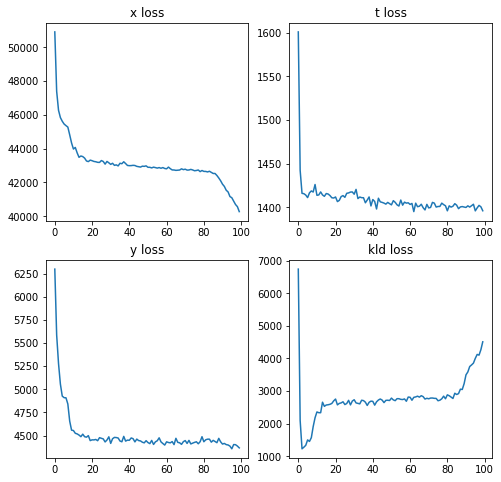

Estimated causal effect: [-0.04305844  0.20106542] true value: [0, 0.1]
Training data size 3000, run 8


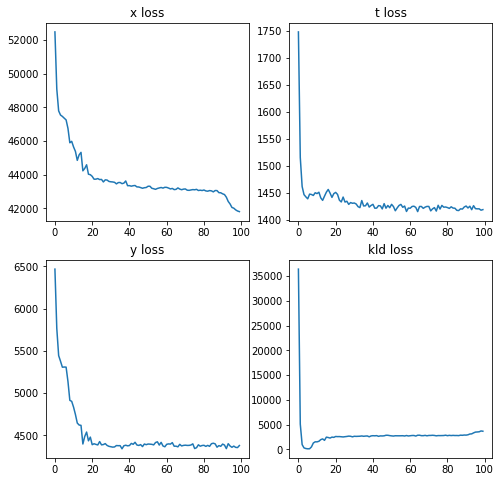

Estimated causal effect: [-0.00477356  0.04652056] true value: [0, 0.1]
Training data size 3000, run 9


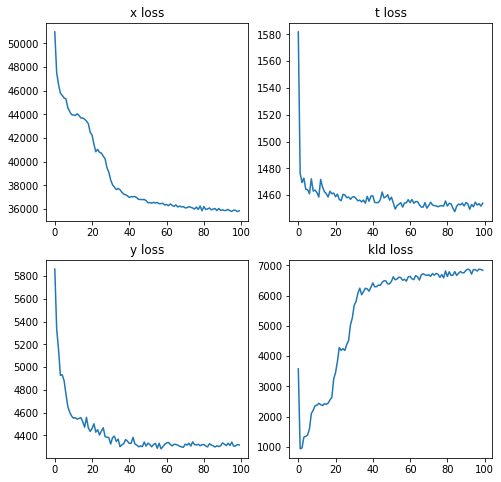

Estimated causal effect: [0.01387836 0.07516315] true value: [0, 0.1]
Training data size 3000, run 10


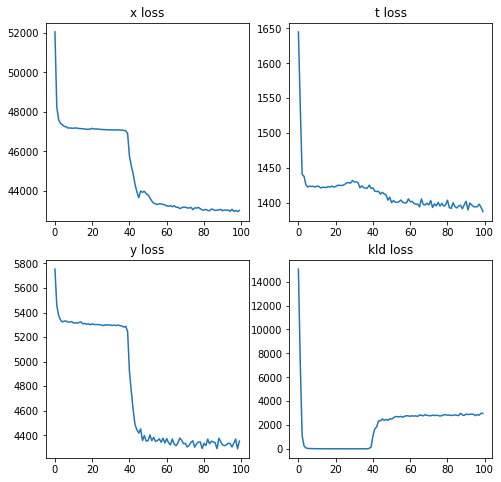

Estimated causal effect: [-0.03615551  0.06569719] true value: [0, 0.1]
Training data size 4000, run 1


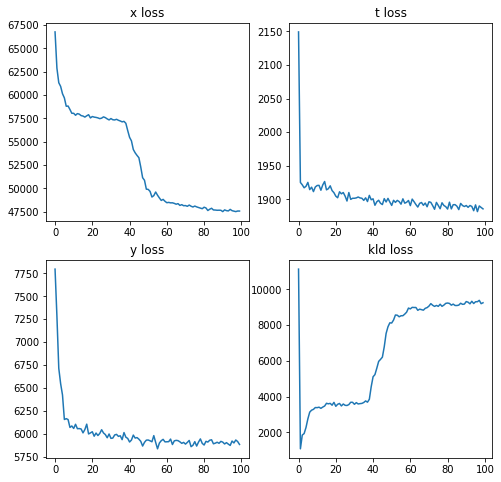

Estimated causal effect: [0.00952091 0.11506594] true value: [0, 0.1]
Training data size 4000, run 2


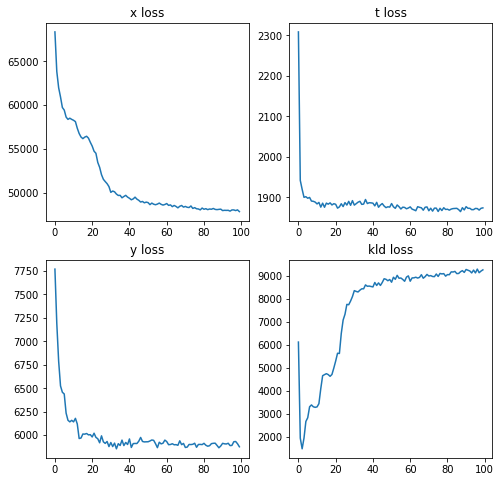

Estimated causal effect: [-0.0254435   0.00429669] true value: [0, 0.1]
Training data size 4000, run 3


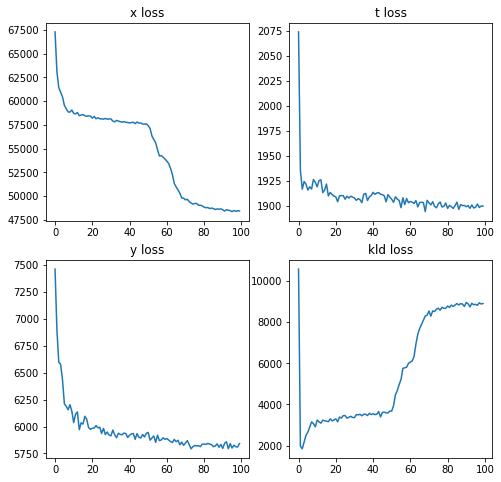

Estimated causal effect: [-0.033168    0.13512866] true value: [0, 0.1]
Training data size 4000, run 4


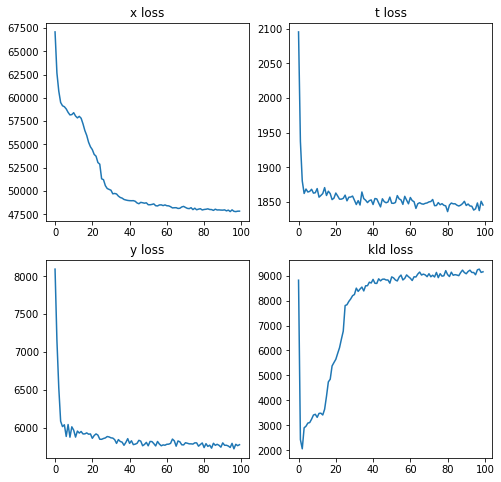

Estimated causal effect: [0.05087602 0.1815436 ] true value: [0, 0.1]
Training data size 4000, run 5


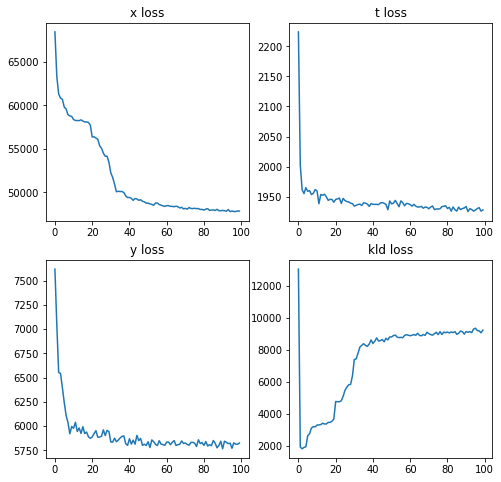

Estimated causal effect: [-0.03196128  0.05116462] true value: [0, 0.1]
Training data size 4000, run 6


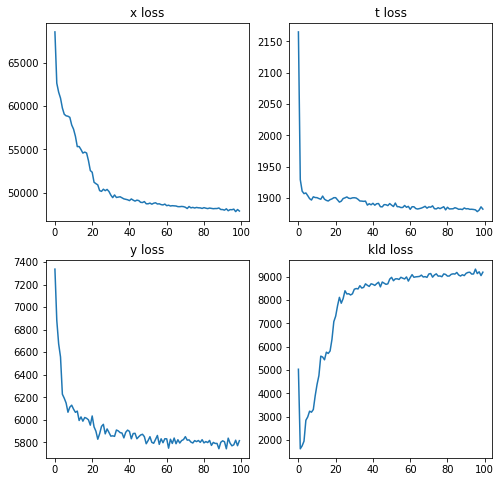

Estimated causal effect: [-0.02412668  0.08586937] true value: [0, 0.1]
Training data size 4000, run 7


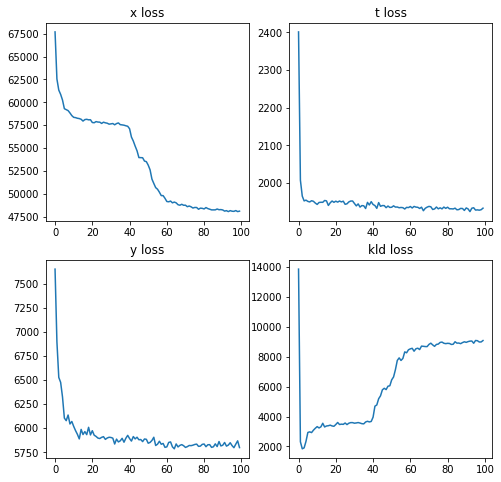

Estimated causal effect: [0.00451497 0.16290905] true value: [0, 0.1]
Training data size 4000, run 8


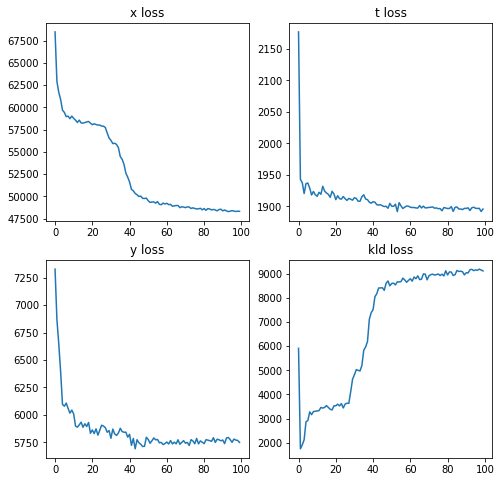

Estimated causal effect: [-0.01676788  0.04868658] true value: [0, 0.1]
Training data size 4000, run 9


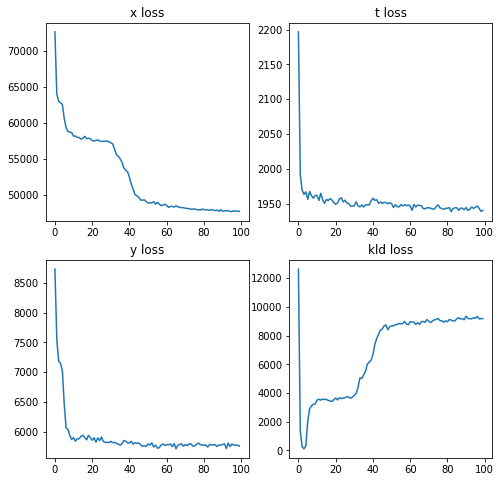

Estimated causal effect: [-0.00725418  0.15789431] true value: [0, 0.1]
Training data size 4000, run 10


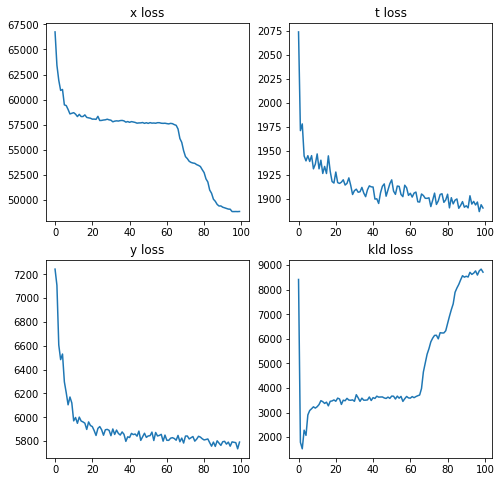

Estimated causal effect: [-0.02993384  0.10756118] true value: [0, 0.1]
Training data size 5000, run 1


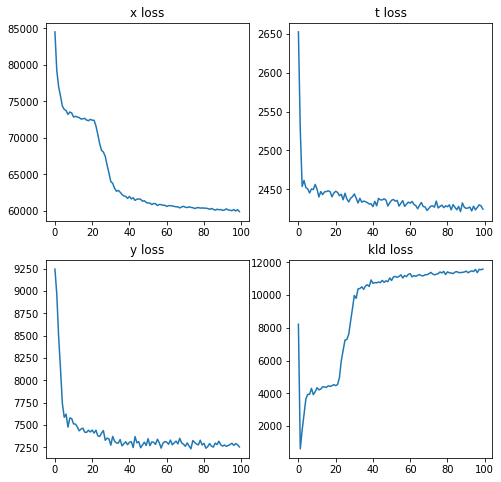

Estimated causal effect: [-0.01393891  0.15123333] true value: [0, 0.1]
Training data size 5000, run 2


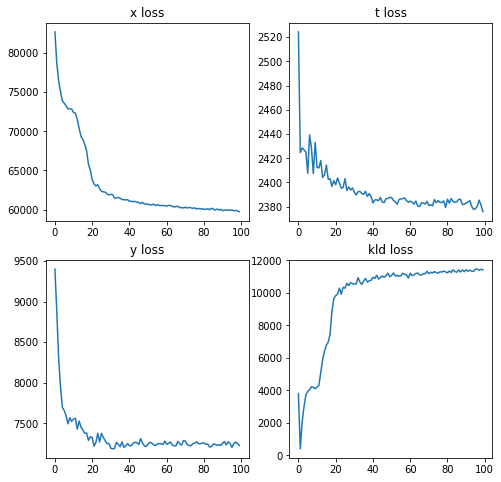

Estimated causal effect: [-0.02049407  0.09677731] true value: [0, 0.1]
Training data size 5000, run 3


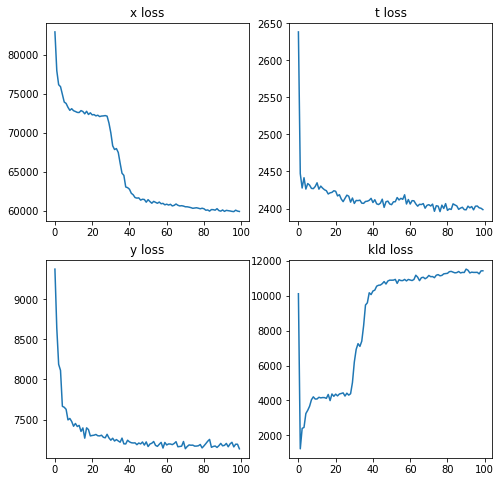

Estimated causal effect: [-0.00196507  0.10967217] true value: [0, 0.1]
Training data size 5000, run 4


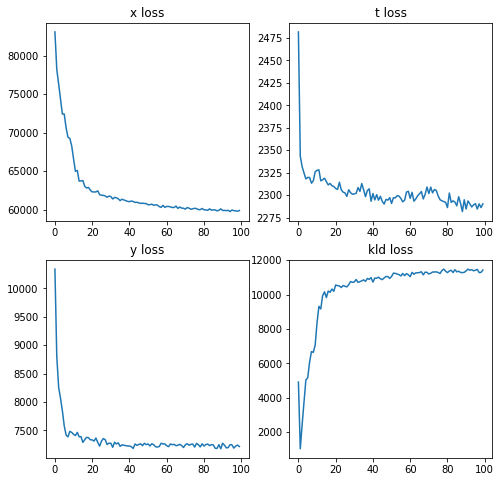

Estimated causal effect: [0.01957358 0.15184812] true value: [0, 0.1]
Training data size 5000, run 5


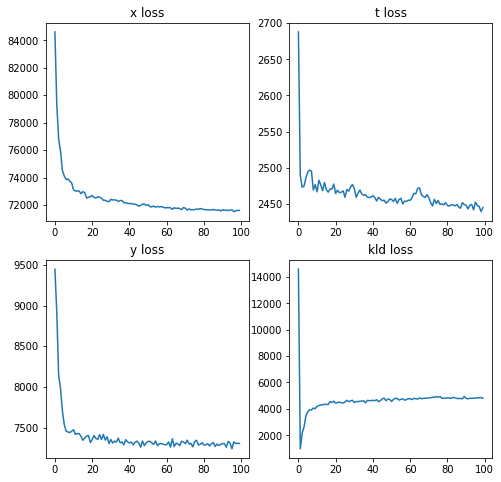

Estimated causal effect: [-0.04559753  0.08116371] true value: [0, 0.1]
Training data size 5000, run 6


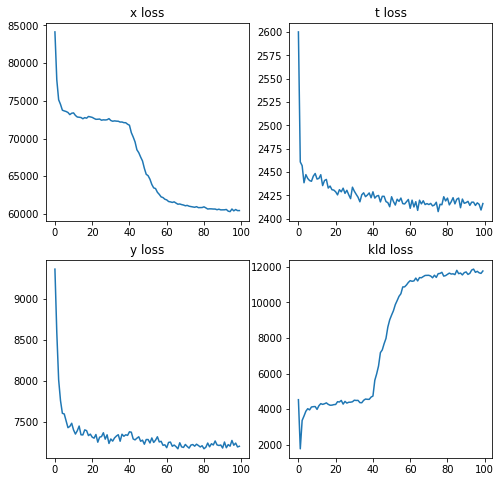

Estimated causal effect: [-0.01245304  0.10438889] true value: [0, 0.1]
Training data size 5000, run 7


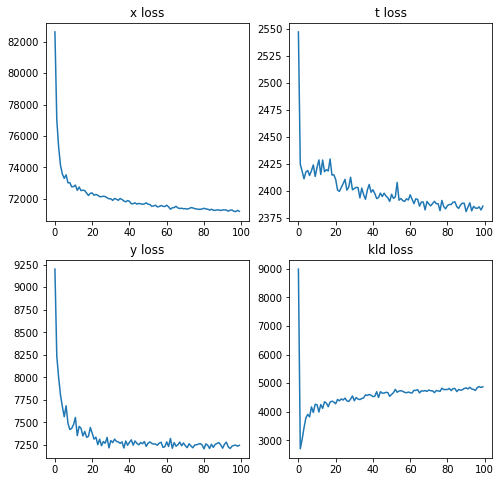

Estimated causal effect: [0.02182577 0.15554947] true value: [0, 0.1]
Training data size 5000, run 8


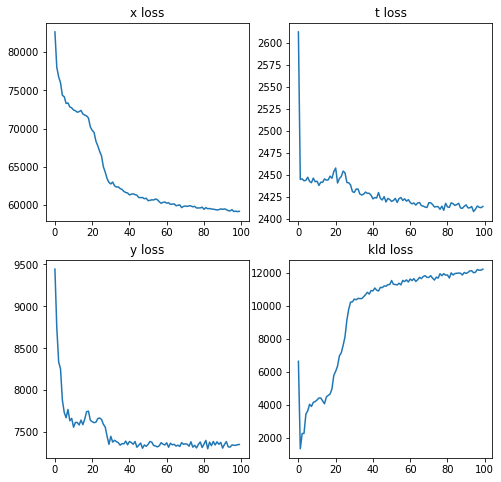

Estimated causal effect: [-0.01855763  0.08463211] true value: [0, 0.1]
Training data size 5000, run 9


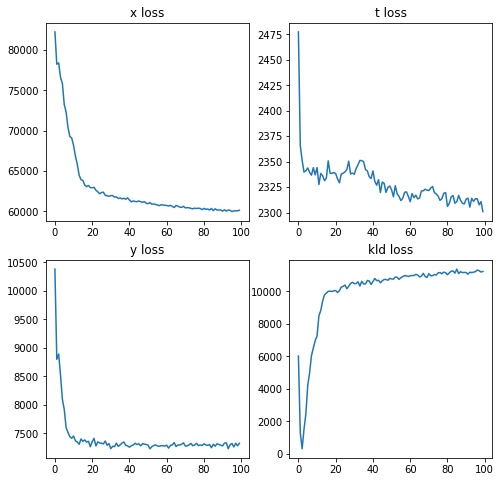

Estimated causal effect: [-0.02338961  0.0943473 ] true value: [0, 0.1]
Training data size 5000, run 10


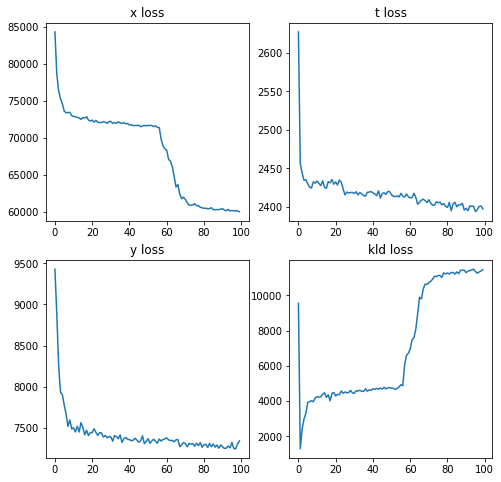

Estimated causal effect: [-0.00026268  0.12659416] true value: [0, 0.1]


In [179]:
datas, models, losses = run_model_for_data_sets(datasize, param_times,
                            folder, name, 
                            BATCH_SIZE, generate_data, dataparameters, track_function, true_value,
                            device, train_arguments, labels,
                           share_data_between_runs=False)

In [190]:
dfs, models, losses = load_dfs_models(folder, name, train_arguments, datasize, labels, device)

In [194]:
p_y_dot1_true = 0.1
p_y_dot0_true = 0

In [201]:
estimate_model_py_dot(models['5000'][9])

array([-0.00870042,  0.15820239])

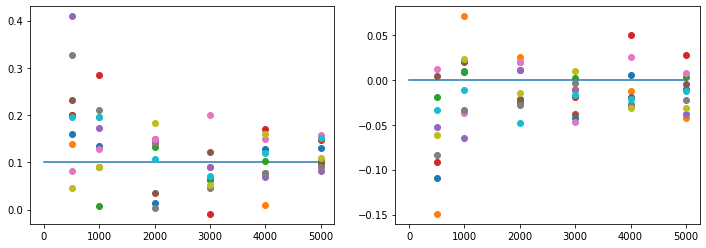

In [202]:
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot([0,5000],2*[p_y_dot1_true],'-')
ax[1].plot([0,5000],2*[p_y_dot0_true],'-')
ates_np = np.zeros((len(datasize), param_times))
pydot1s_np = np.zeros((len(datasize), param_times))
pydot0s_np = np.zeros((len(datasize), param_times))

for i,dsize in enumerate(map(str,datasize)):
    for j in range(len(models[dsize])):
        pydot0,pydot1 = estimate_model_py_dot(models[dsize][j])
        pydot1s_np[i,j] = pydot1
        pydot0s_np[i,j] = pydot0
        ax[0].plot([int(dsize)],[pydot1],'o',color='C'+str(j))
        ax[1].plot([int(dsize)],[pydot0],'o',color='C'+str(j))

In [205]:
final_losses = {zd:dict() for zd in losses}
for dsize in losses:
    for j in range(param_times):
        final_losses[dsize][j] = losses[dsize][j]['total'][-1]

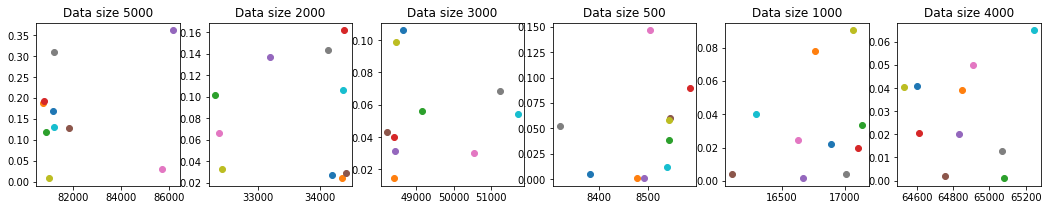

In [213]:
"""Loss vs ATE error"""
fig, ax = plt.subplots(1,6,figsize=(18,3))
for i,dsize in enumerate(losses):
    ax[i].set_title("Data size {}".format(dsize))
    for j in range(param_times):
        ax[i].plot(final_losses[dsize][j], np.abs((pydot1s_np[i,j] - pydot0s_np[i,j])-0.1),'o')

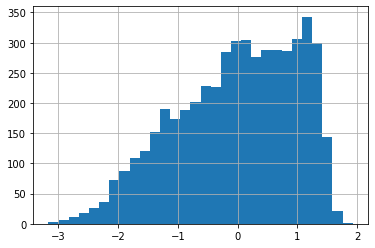

In [222]:
dfs["5000"][0]["z"].hist(bins=30)
mean = df["z"].mean()
std = df["z"].std()


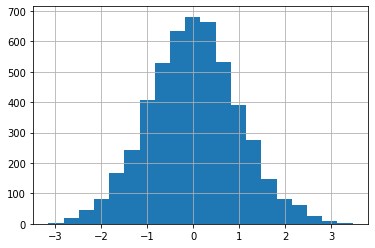

In [251]:
generate_data(5000,*dataparameters)['x3'].hist(bins=20)

## Notes
- Choice of variable as z matters: preferably normally distributed, but also the other variables should have enough information about it so that the models don't end up just estimating y|t directly in lack of other data
    - Seems that the latter is a problem with the fourth x, and the former with the first
    - The binary vars might be good because at least should correlate with some others
        - Would probably need the binary z if our conclusions are right